In [11]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
import itertools
import scipy.stats as st
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
import rpy2
#import pingouin as pg
from itertools import combinations

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.ipython.html
rpy2.ipython.html.init_printing()
from rpy2.rinterface_lib.embedded import RRuntimeError

# import R's "utils" package
utils = importr('utils')
lavaan = importr('lavaan')
semtools = importr('semTools')
stringr = importr('stringr')
reticulate = importr('reticulate')
#lavaanPlot = importr('lavaanPlot')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [12]:
# importing stuff the right way
try:
    semTools_version = '.'.join([str(ii) for ii in list(ro.r('packageVersion("semTools")')[0])])
except RRuntimeError:
    semTools_version = ''
# There's a bug in the main semtools libarary, this install from my fork of semtools where I've fixed it.
if semTools_version != '0.5.6.933':
    ro.r("""
        library(devtools)
        install_github("shotgunosine/semTools/semTools@aa68e38f88d9dd881617d5ade429bde2b2a74e08")
        """
    )

In [13]:
# general
#data_path = '../data/mydata_1general_forCFA_removedchecks.csv'
#path_to_save = '../results/CFA_general_removedchecks.csv'

data_path = '../data/mydata_1general_forCFA_removedGRIDchecks.csv'
path_to_save = '../results/CFA_general_removedGRIDchecks.csv'

#data_path = '../data/mydata_1general_forCFA.csv'
#path_to_save = '../results/CFA_general.csv'

#highrisk
#data_path = '../data/mydata_1highrisk_forCFA_removedchecks.csv'
#path_to_save = '../results/CFA_highrisk_removedchecks.csv'

#data_path = '../data/mydata_1highrisk_forCFA_removedGRIDchecks.csv'
#path_to_save = '../results/CFA_highrisk_removedGRIDchecks.csv'

#data_path = '../data/mydata_1highrisk_forCFA.csv'
#path_to_save = '../results/CFA_highrisk.csv'

mydata = pd.read_csv(data_path)
mydata = mydata.rename(columns={'Unnamed: 0': 'Subject'})
mydata.head()

,Subject,hitop_sum,hitop_sum_recontact,baars_sum,baars_sum_recontact,phq_sum,phq_sum_recontact,gad_sum,gad_sum_recontact,mood_bothered,mood_bothered_recontact,anxiety_bothered,anxiety_bothered_recontact,attention_bothered,attention_bothered_recontact,moodanxiety_bothered,moodanxiety_bothered_recontact,baars_inattention_sum,baars_inattention_sum_recontact,baars_hyperactivity_sum,baars_hyperactivity_sum_recontact,baars_impulsivity_sum,baars_impulsivity_sum_recontact,baars_sct_sum,baars_sct_sum_recontact,hitop_anhedonic_depression,hitop_anhedonic_depression_recontact,hitop_anxious_worry,hitop_anxious_worry_recontact,hitop_appetite_gain,hitop_appetite_gain_recontact,hitop_appetite_loss,hitop_appetite_loss_recontact,hitop_cognitive_problems,hitop_cognitive_problems_recontact,hitop_hyposomnia,hitop_hyposomnia_recontact,hitop_indecisiveness,hitop_indecisiveness_recontact,hitop_insomnia,hitop_insomnia_recontact,hitop_panic,hitop_panic_recontact,hitop_separation_insecurity,hitop_separation_insecurity_recontact,hitop_shame_guilt,hitop_shame_guilt_recontact,hitop_situational_phobia,hitop_situational_phobia_recontact,hitop_social_anxiety,hitop_social_anxiety_recontact,hitop_well_being,hitop_well_being_recontact,inattention_1,inattention_2,inattention_3,inattention_4,inattention_5,inattention_6,inattention_7,inattention_8,inattention_9,hyperactivity_1,hyperactivity_2,hyperactivity_3,hyperactivity_4,hyperactivity_5,impulsivity_1,impulsivity_2,impulsivity_3,impulsivity_4,inattention_1_recontact,inattention_2_recontact,inattention_3_recontact,inattention_4_recontact,inattention_5_recontact,inattention_6_recontact,inattention_7_recontact,inattention_8_recontact,inattention_9_recontact,hyperactivity_1_recontact,hyperactivity_2_recontact,hyperactivity_3_recontact,hyperactivity_4_recontact,hyperactivity_5_recontact,impulsivity_1_recontact,impulsivity_2_recontact,impulsivity_3_recontact,impulsivity_4_recontact,gad_1,gad_2,gad_3,gad_4,gad_5,gad_6,gad_7,phq_1,phq_2,phq_3,phq_4,phq_5,phq_6,phq_7,phq_8,sct_1,sct_2,sct_3,sct_4,sct_5,sct_6,sct_7,sct_8,sct_9,gad_1_recontact,gad_2_recontact,gad_3_recontact,gad_4_recontact,gad_5_recontact,gad_6_recontact,gad_7_recontact,phq_1_recontact,phq_2_recontact,phq_3_recontact,phq_4_recontact,phq_5_recontact,phq_6_recontact,phq_7_recontact,phq_8_recontact,sct_1_recontact,sct_2_recontact,sct_3_recontact,sct_4_recontact,sct_5_recontact,sct_6_recontact,sct_7_recontact,sct_8_recontact,sct_9_recontact,hitop157,hitop157_recontact,hitop81,hitop81_recontact,hitop34,hitop34_recontact,hitop54,hitop54_recontact,hitop243,hitop243_recontact,hitop182,hitop182_recontact,hitop69,hitop69_recontact,hitop89,hitop89_recontact,hitop50,hitop50_recontact,hitop129,hitop129_recontact,hitop265,hitop265_recontact,hitop124,hitop124_recontact,hitop231,hitop231_recontact,hitop93,hitop93_recontact,hitop67,hitop67_recontact,hitop245,hitop245_recontact,hitop281,hitop281_recontact,hitop141,hitop141_recontact,hitop40,hitop40_recontact,hitop204,hitop204_recontact,hitop21,hitop21_recontact,hitop236,hitop236_recontact,hitop280,hitop280_recontact,hitop84,hitop84_recontact,hitop120,hitop120_recontact,hitop77,hitop77_recontact,hitop92,hitop92_recontact,hitop258,hitop258_recontact,hitop39,hitop39_recontact,hitop254,hitop254_recontact,hitop215,hitop215_recontact,hitop95,hitop95_recontact,hitop106,hitop106_recontact,hitop283,hitop283_recontact,hitop16,hitop16_recontact,hitop20,hitop20_recontact,hitop189,hitop189_recontact,hitop1,hitop1_recontact,hitop136,hitop136_recontact,hitop246,hitop246_recontact,hitop248,hitop248_recontact,hitop257,hitop257_recontact,hitop114,hitop114_recontact,hitop117,hitop117_recontact,hitop250,hitop250_recontact,hitop200,hitop200_recontact,hitop160,hitop160_recontact,hitop23,hitop23_recontact,hitop165,hitop165_recontact,hitop244,hitop244_recontact,hitop9,hitop9_recontact,hitop142,hitop142_recontact,hitop230,hitop230_recontact,hitop149,hitop149_recontact,hitop247,hitop247_recontact,hitop99,hitop99_recontact,hitop66,hitop66_recontact,h

In [14]:
def prep_data_recontactanalysis(dataframe_withrecontact):
    df = dataframe_withrecontact
    df_helper = df.copy(deep=True)
    df_rows = df.shape[0]
    df = df.assign(whichvisit=['initialvisit']*df_rows)
    df_helper = df_helper.assign(whichvisit=['recontactvisit']*df_rows)
    # in df, drop all "recontact" columns
    # in df_helper, drop all initial visit columns, then rename the recontact columns
    cols_recontact = []
    cols_original = []
    for c in df.columns:
        if "recontact" in c:
            cols_recontact.append(c)
            cols_original.append(c[:-10])  
    df = df.drop(columns=cols_recontact)
    df_helper = df_helper.drop(columns=cols_original)
    cols_dict = {}
    for cname in cols_recontact:
        cols_dict[cname] = cname[:-10]
    # rename cols in df_helper
    df_helper.rename(columns=cols_dict, inplace=True)    
    mydata_withrecontact = pd.concat([df, df_helper])
    return(mydata_withrecontact)

mydata_forcfa = prep_data_recontactanalysis(mydata)
mydata_forcfa.head(100)

,Subject,hitop_sum,baars_sum,phq_sum,gad_sum,mood_bothered,anxiety_bothered,attention_bothered,moodanxiety_bothered,baars_inattention_sum,baars_hyperactivity_sum,baars_impulsivity_sum,baars_sct_sum,hitop_anhedonic_depression,hitop_anxious_worry,hitop_appetite_gain,hitop_appetite_loss,hitop_cognitive_problems,hitop_hyposomnia,hitop_indecisiveness,hitop_insomnia,hitop_panic,hitop_separation_insecurity,hitop_shame_guilt,hitop_situational_phobia,hitop_social_anxiety,hitop_well_being,inattention_1,inattention_2,inattention_3,inattention_4,inattention_5,inattention_6,inattention_7,inattention_8,inattention_9,hyperactivity_1,hyperactivity_2,hyperactivity_3,hyperactivity_4,hyperactivity_5,impulsivity_1,impulsivity_2,impulsivity_3,impulsivity_4,gad_1,gad_2,gad_3,gad_4,gad_5,gad_6,gad_7,phq_1,phq_2,phq_3,phq_4,phq_5,phq_6,phq_7,phq_8,sct_1,sct_2,sct_3,sct_4,sct_5,sct_6,sct_7,sct_8,sct_9,hitop157,hitop81,hitop34,hitop54,hitop243,hitop182,hitop69,hitop89,hitop50,hitop129,hitop265,hitop124,hitop231,hitop93,hitop67,hitop245,hitop281,hitop141,hitop40,hitop204,hitop21,hitop236,hitop280,hitop84,hitop120,hitop77,hitop92,hitop258,hitop39,hitop254,hitop215,hitop95,hitop106,hitop283,hitop16,hitop20,hitop189,hitop1,hitop136,hitop246,hitop248,hitop257,hitop114,hitop117,hitop250,hitop200,hitop160,hitop23,hitop165,hitop244,hitop9,hitop142,hitop230,hitop149,hitop247,hitop99,hitop66,hitop240,hitop222,hitop90,hitop113,hitop278,hitop203,hitop159,hitop123,hitop275,hitop268,hitop225,hitop143,hitop151,hitop181,hitop211,hitop17,hitop126,hitop5,hitop261,hitop220,hitop15,hitop72,hitop140,hitop109,hitop197,hitop104,todayhitop157,todayhitop81,todayhitop34,todayhitop54,todayhitop243,todayhitop182,todayhitop69,todayhitop89,todayhitop50,todayhitop129,todayhitop265,todayhitop124,todayhitop231,todayhitop93,todayhitop67,todayhitop245,todayhitop281,todayhitop141,todayhitop40,todayhitop204,todayhitop21,todayhitop236,todayhitop280,todayhitop84,todayhitop120,todayhitop77,todayhitop92,todayhitop258,todayhitop39,todayhitop254,todayhitop215,todayhitop95,todayhitop106,todayhitop283,todayhitop16,todayhitop20,todayhitop189,todayhitop1,todayhitop136,todayhitop246,todayhitop248,todayhitop257,todayhitop114,todayhitop117,todayhitop250,todayhitop200,todayhitop160,todayhitop23,todayhitop165,todayhitop244,todayhitop9,todayhitop142,todayhitop230,todayhitop149,todayhitop247,todayhitop99,todayhitop66,todayhitop240,todayhitop222,todayhitop90,todayhitop113,todayhitop278,todayhitop203,todayhitop159,todayhitop123,todayhitop275,todayhitop268,todayhitop225,todayhitop143,todayhitop151,todayhitop181,todayhitop211,todayhitop17,todayhitop126,todayhitop5,todayhitop261,todayhitop220,todayhitop15,todayhitop72,todayhitop140,todayhitop109,todayhitop197,todayhitop104,whichvisit
0,0,39,16,7,10,False,False,False,False,7,7,2,15,2,11,5,0,6,0,3,1,0,4,2,0,5,28,0,1,0,0,0,1,0,3,2,1,0,1,2,3,0,2,0,0,2,2,2,2,1,1,0,0,1,0,3,0,2,1,0,0,1,2,1,3,2,3,3,0,1,1,2,3,2,1,1,1,0,1,2,0,0,0,1,3,3,2,0,1,1,1,0,0,0,0,0,0,0,0,0,1,2,0,0,1,3,1,1,0,1,0,0,1,3,2,0,3,0,3,3,1,0,3,0,0,0,1,0,1,0,0,3,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,initialvisit
1,1,93,12,4,6,False,False,False,False,6,3,3,11,10,13,5,2,6,5,3,4,12,3,3,10,17,27,1,1,1,0,0,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,1,0,0,1,0,1,0,1,1,2,2,1,2,1,1,1,1,0,1,0,3,3,0,2,0,2,0,1,3,2,0,1,2,3,3,3,1,3,1,2,1,0,1,3,1,1,0,1,0,1,3,0,2,3,1,2,0,1,1,3,1,1,0,3,2,3,3,3,3,1,1,3,3,1,2,1,3,1,1,1,0,2,0,1,0,1,1,1,1,3,1,2,1,1,1,2,0,1,1,0,2,2,2,1,1,2,2,2,2,2,2,1,2,2,2,2,1,2,1,2,2,1,2,2,2,2,2,2,1,2,1,2,2,1,2,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,1,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,initialvisit
2,3,17,4,0,0,False,False,False,False,4,0,0,3,1,0,3,0,1,0,0,6,1,0,0,4,1,13,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0

In [15]:
def print_summary(obj):
    return rprint(summary(obj))

def print_short_summary(invariance_output):
    ro.r("myoutput <- capture.output(summary(invariance_output))") 
    ro.r("stringid <- grep(\"chisq\", myoutput)")
    ro.r("print(myoutput[stringid-1])")
    ro.r("print(myoutput[stringid])")
    return (0)

def print_problematic_items(invariance_output):
    ro.r("myoutput <- capture.output(summary(invariance_output))") 
    print('Problematic items:')
    ro.r("stringidsig <- grep(\"may differ between Groups\", myoutput)")
    ro.r("print(myoutput[stringidsig])")   
    return (0)
    
def extract_p(invariance_output):
    ro.globalenv['invariance_output'] = invariance_output
    ro.r("myoutput <- capture.output(summary(invariance_output))") 
    ro.r("stringid <- grep(\"chisq\", myoutput)")
    ro.r('myrline <- myoutput[stringid]')
    mypline = ro.r('myrline')[0]
    my_p = mypline.split()[-1]
    return(my_p)

def check_secondary_criteria(fit_config):
    Criteria_passed = False
    ro.r("myoutputconfig <- capture.output(summary(fit_config, fit.measures=TRUE))")
    ro.r("stringid_cfi <- grep(\"Robust.*CFI\", myoutputconfig)")
    ro.r("cfi_line <- myoutputconfig[stringid_cfi]")
    cfiline = ro.r('cfi_line')[0]    
    my_cfi = cfiline.split()[-1] 
    my_cfi = float(my_cfi)
    ro.r("stringid_tli <- grep(\"Robust.*TLI\", myoutputconfig)")
    ro.r("tli_line <- myoutputconfig[stringid_tli]")
    tliline = ro.r('tli_line')[0]    
    my_tli = tliline.split()[-1] 
    my_tli = float(my_tli)
    ro.r("stringid_rmsea <- grep(\"Robust.*RMSEA\", myoutputconfig)")
    ro.r("rmsea_line <- myoutputconfig[stringid_rmsea]")
    myrmsealine = ro.r('rmsea_line')[0]
    my_rmsea = myrmsealine.split('\n')[0].split()[-1]
    my_rmsea = float(my_rmsea)   
    if (my_cfi > 0.95) and (my_tli > 0.95) and (my_rmsea < 0.06):
        Criteria_passed = True
    return (Criteria_passed, my_cfi, my_tli, my_rmsea)

In [16]:
for c in mydata_forcfa.columns:
    print(c)

Subject
hitop_sum
baars_sum
phq_sum
gad_sum
mood_bothered
anxiety_bothered
attention_bothered
moodanxiety_bothered
baars_inattention_sum
baars_hyperactivity_sum
baars_impulsivity_sum
baars_sct_sum
hitop_anhedonic_depression
hitop_anxious_worry
hitop_appetite_gain
hitop_appetite_loss
hitop_cognitive_problems
hitop_hyposomnia
hitop_indecisiveness
hitop_insomnia
hitop_panic
hitop_separation_insecurity
hitop_shame_guilt
hitop_situational_phobia
hitop_social_anxiety
hitop_well_being
inattention_1
inattention_2
inattention_3
inattention_4
inattention_5
inattention_6
inattention_7
inattention_8
inattention_9
hyperactivity_1
hyperactivity_2
hyperactivity_3
hyperactivity_4
hyperactivity_5
impulsivity_1
impulsivity_2
impulsivity_3
impulsivity_4
gad_1
gad_2
gad_3
gad_4
gad_5
gad_6
gad_7
phq_1
phq_2
phq_3
phq_4
phq_5
phq_6
phq_7
phq_8
sct_1
sct_2
sct_3
sct_4
sct_5
sct_6
sct_7
sct_8
sct_9
hitop157
hitop81
hitop34
hitop54
hitop243
hitop182
hitop69
hitop89
hitop50
hitop129
hitop265
hitop124
hitop231


In [17]:
mydata_forcfa.head()

,Subject,hitop_sum,baars_sum,phq_sum,gad_sum,mood_bothered,anxiety_bothered,attention_bothered,moodanxiety_bothered,baars_inattention_sum,baars_hyperactivity_sum,baars_impulsivity_sum,baars_sct_sum,hitop_anhedonic_depression,hitop_anxious_worry,hitop_appetite_gain,hitop_appetite_loss,hitop_cognitive_problems,hitop_hyposomnia,hitop_indecisiveness,hitop_insomnia,hitop_panic,hitop_separation_insecurity,hitop_shame_guilt,hitop_situational_phobia,hitop_social_anxiety,hitop_well_being,inattention_1,inattention_2,inattention_3,inattention_4,inattention_5,inattention_6,inattention_7,inattention_8,inattention_9,hyperactivity_1,hyperactivity_2,hyperactivity_3,hyperactivity_4,hyperactivity_5,impulsivity_1,impulsivity_2,impulsivity_3,impulsivity_4,gad_1,gad_2,gad_3,gad_4,gad_5,gad_6,gad_7,phq_1,phq_2,phq_3,phq_4,phq_5,phq_6,phq_7,phq_8,sct_1,sct_2,sct_3,sct_4,sct_5,sct_6,sct_7,sct_8,sct_9,hitop157,hitop81,hitop34,hitop54,hitop243,hitop182,hitop69,hitop89,hitop50,hitop129,hitop265,hitop124,hitop231,hitop93,hitop67,hitop245,hitop281,hitop141,hitop40,hitop204,hitop21,hitop236,hitop280,hitop84,hitop120,hitop77,hitop92,hitop258,hitop39,hitop254,hitop215,hitop95,hitop106,hitop283,hitop16,hitop20,hitop189,hitop1,hitop136,hitop246,hitop248,hitop257,hitop114,hitop117,hitop250,hitop200,hitop160,hitop23,hitop165,hitop244,hitop9,hitop142,hitop230,hitop149,hitop247,hitop99,hitop66,hitop240,hitop222,hitop90,hitop113,hitop278,hitop203,hitop159,hitop123,hitop275,hitop268,hitop225,hitop143,hitop151,hitop181,hitop211,hitop17,hitop126,hitop5,hitop261,hitop220,hitop15,hitop72,hitop140,hitop109,hitop197,hitop104,todayhitop157,todayhitop81,todayhitop34,todayhitop54,todayhitop243,todayhitop182,todayhitop69,todayhitop89,todayhitop50,todayhitop129,todayhitop265,todayhitop124,todayhitop231,todayhitop93,todayhitop67,todayhitop245,todayhitop281,todayhitop141,todayhitop40,todayhitop204,todayhitop21,todayhitop236,todayhitop280,todayhitop84,todayhitop120,todayhitop77,todayhitop92,todayhitop258,todayhitop39,todayhitop254,todayhitop215,todayhitop95,todayhitop106,todayhitop283,todayhitop16,todayhitop20,todayhitop189,todayhitop1,todayhitop136,todayhitop246,todayhitop248,todayhitop257,todayhitop114,todayhitop117,todayhitop250,todayhitop200,todayhitop160,todayhitop23,todayhitop165,todayhitop244,todayhitop9,todayhitop142,todayhitop230,todayhitop149,todayhitop247,todayhitop99,todayhitop66,todayhitop240,todayhitop222,todayhitop90,todayhitop113,todayhitop278,todayhitop203,todayhitop159,todayhitop123,todayhitop275,todayhitop268,todayhitop225,todayhitop143,todayhitop151,todayhitop181,todayhitop211,todayhitop17,todayhitop126,todayhitop5,todayhitop261,todayhitop220,todayhitop15,todayhitop72,todayhitop140,todayhitop109,todayhitop197,todayhitop104,whichvisit
0,0,39,16,7,10,False,False,False,False,7,7,2,15,2,11,5,0,6,0,3,1,0,4,2,0,5,28,0,1,0,0,0,1,0,3,2,1,0,1,2,3,0,2,0,0,2,2,2,2,1,1,0,0,1,0,3,0,2,1,0,0,1,2,1,3,2,3,3,0,1,1,2,3,2,1,1,1,0,1,2,0,0,0,1,3,3,2,0,1,1,1,0,0,0,0,0,0,0,0,0,1,2,0,0,1,3,1,1,0,1,0,0,1,3,2,0,3,0,3,3,1,0,3,0,0,0,1,0,1,0,0,3,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,initialvisit
1,1,93,12,4,6,False,False,False,False,6,3,3,11,10,13,5,2,6,5,3,4,12,3,3,10,17,27,1,1,1,0,0,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,1,0,0,1,0,1,0,1,1,2,2,1,2,1,1,1,1,0,1,0,3,3,0,2,0,2,0,1,3,2,0,1,2,3,3,3,1,3,1,2,1,0,1,3,1,1,0,1,0,1,3,0,2,3,1,2,0,1,1,3,1,1,0,3,2,3,3,3,3,1,1,3,3,1,2,1,3,1,1,1,0,2,0,1,0,1,1,1,1,3,1,2,1,1,1,2,0,1,1,0,2,2,2,1,1,2,2,2,2,2,2,1,2,2,2,2,1,2,1,2,2,1,2,2,2,2,2,2,1,2,1,2,2,1,2,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,1,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,initialvisit
2,3,17,4,0,0,False,False,False,False,4,0,0,3,1,0,3,0,1,0,0,6,1,0,0,4,1,13,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0

In [18]:
mydata = mydata_forcfa
whichcolumn = 'genpop_withrecontact'

assert(whichcolumn in ['enriched_withrecontact', 'genpop_withrecontact'])
num_iter = 1000
rprint = ro.r('print')
summary = ro.r('summary')
ro.r('set.seed(12345)')
rngkind = "L'Ecuyer-CMRG"

mdl_strs_new_new = {'hitop_SUM': 'hitop_SUM =~hitop_anhedonic_depression + hitop_anxious_worry + hitop_appetite_gain + hitop_appetite_loss + hitop_cognitive_problems + hitop_hyposomnia + hitop_indecisiveness + hitop_insomnia + hitop_panic + hitop_separation_insecurity + hitop_shame_guilt + hitop_situational_phobia + hitop_social_anxiety', 
'baars_SUM': 'baars_SUM =~inattention_sum + hyperactivity_sum + impulsivity_sum + sct_sum',
'phq_SUM': 'phq_SUM =~phq_1 + phq_2 + phq_3 + phq_4 + phq_5 + phq_6 + phq_7 + phq_8',
'gad_SUM': 'gad_SUM =~gad_1 + gad_2 + gad_3 + gad_4 + gad_5 + gad_6 + gad_7',
'baars_inattention_SUM': 'baars_inattention_SUM =~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9',
'baars_hyperactivity_SUM': 'baars_hyperactivity_SUM =~hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5',
'baars_impulsivity_SUM': 'baars_impulsivity_SUM =~impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4',
'baars_sct_SUM': 'baars_sct_SUM =~sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9'}

if whichcolumn == 'enriched_withrecontact':
    mydata.to_csv('../data/CFA/data_enriched.csv')
    ro.r("rdata <- read.csv('../data/CFA/data_enriched.csv', header=TRUE)") 
    group = 'whichvisit'
elif whichcolumn == 'genpop_withrecontact':
    mydata.to_csv('../data/CFA/data_genpop.csv')
    ro.r("rdata <- read.csv('../data/CFA/data_genpop.csv', header=TRUE)")
    group = 'whichvisit'

ro.globalenv['group'] = group

# CFA
df_data = []    
for cln_ss, mdl in mdl_strs_new_new.items():
    do_metric = False
    do_scalar = False
    do_strict = False
    print("\n\n\n================================")
    print("================================")
    print(cln_ss.upper())
    print(mdl)
    print("================================")
    print("================================")
    # ====== CONFIG =====        
    ro.globalenv[cln_ss+'_mdl'] = mdl_strs_new_new[cln_ss]
    fit_config = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV")')
    ro.globalenv['fit_config'] = fit_config        
    print("----------------")
    out_config = semtools.permuteMeasEq(nPermute=num_iter, # 100 for now, 1000 for the "real" run
                                                con=fit_config, # In the case of testing configural invariance when modelType = "mgcfa", con is the configural model (implicitly, the unconstrained model is the saturated model, so use the defaults uncon = NULL and param = NULL).
                                                parallelType="multicore", ncpus=4)
    config_p = extract_p(out_config)
    if float(config_p) >= 0.05:
        print('CONFIG INVARIANT chisq p = ' + str(config_p))
        do_metric = True
    else:
        (passed_flag, my_cfi, my_tli, my_rmsea) = check_secondary_criteria(fit_config)
        if passed_flag:
            print('CONFIG chisq p = ' + str(config_p))
            print('PASSED SECONDARY CRITERIA WITH CFI = ' + str(my_cfi) + ' TLI = ' + str(my_tli) + ' RMSEA = ' + str(my_rmsea))
            do_metric = True
        else:
            print('CONFIG INVARIANT NOT PASSED, chisq p = ' + str(config_p))
       
    if do_metric:

        # ====== METRIC =====
        fit_metric = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal="loadings")')
        ro.globalenv['fit_metric'] = fit_metric
        out_metric = semtools.permuteMeasEq(nPermute=num_iter, 
                                                uncon=fit_config, 
                                                con=fit_metric, 
                                                param="loadings",
                                                parallelType="multicore", ncpus=4)
        metric_p = extract_p(out_metric)
        if float(metric_p) >= 0.05:
            print('METRIC INVARIANT chisq p = ' + str(metric_p))
            do_scalar = True
        else:
            # significant:
            print('METRIC INVARIANT NOT PASSED, chisq p = ' + str(metric_p))
            _ = print_problematic_items(out_metric)
            
        if do_scalar:
            # ====== SCALAR =====
            ro.globalenv['out_metric'] = out_metric
            fit_scalar = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal=c("loadings", "intercepts"))')
            ro.globalenv['fit_scalar'] = fit_scalar
            out_scalar = semtools.permuteMeasEq(nPermute=num_iter, 
                                                uncon=fit_metric, 
                                                con=fit_scalar, 
                                                param=ro.StrVector(["loadings","intercepts"]),
                                                parallelType="multicore", 
                                                ncpus=4)
            scalar_p = extract_p(out_scalar)
            if float(scalar_p) >= 0.05:
                print('SCALAR INVARIANT chisq p = ' + str(scalar_p))
                do_strict = True
            else:
                # significant:
                print('SCALAR INVARIANT NOT PASSED, chisq p = ' + str(scalar_p))
                _ = print_problematic_items(out_scalar)

            if do_strict:

                # ====== STRICT =====
                ro.globalenv['out_scalar'] = out_scalar
                fit_strict = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal=c("loadings", "intercepts", "residuals"))')
                ro.globalenv['fit_strict'] = fit_strict
                out_strict = semtools.permuteMeasEq(nPermute=num_iter, 
                                                        uncon=fit_scalar, 
                                                        con=fit_strict, 
                                                        param=ro.StrVector(["loadings","intercepts", "residuals"]),
                                                        parallelType="multicore", 
                                                        ncpus=4)
                strict_p = extract_p(out_strict)
                if float(strict_p) >= 0.05:
                    print('STRICT INVARIANT chisq p = ' + str(strict_p))
                else:
                    # significant:
                    print('STRICT INVARIANT NOT PASSED, chisq p = ' + str(strict_p))
                    _ = print_problematic_items(out_strict)

            else:
                print('STRICT N/A')
                strict_p = 'NA'
        else:
            print('SCALAR N/A')
            print('STRICT N/A')
            scalar_p = 'NA'
            strict_p = 'NA'
    else:
        print('METRIC N/A')
        print('SCALAR N/A')
        print('STRICT N/A')
        metric_p = 'NA'
        scalar_p = 'NA'
        strict_p = 'NA'
    df_data.append({cln_ss: [config_p, metric_p, scalar_p, strict_p]})
df = pd.DataFrame(df_data)

print('DONE')

R[write to console]: Your RNGkind() was changed from Mersenne-Twister to L'Ecuyer-CMRG, which is required for reproducibility  in parallel jobs.  Your RNGkind() has been returned to Mersenne-Twister but the seed has not been set.  The state of your previous RNG is saved in the slot  named 'oldSeed', if you want to restore it using  the syntax:
.Random.seed[-1] <- permuteMeasEqObject@oldSeed[-1]

R[write to console]: No AFIs were selected, so only chi-squared will be permuted.







HITOP_SUM
hitop_SUM =~hitop_anhedonic_depression + hitop_anxious_worry + hitop_appetite_gain + hitop_appetite_loss + hitop_cognitive_problems + hitop_hyposomnia + hitop_indecisiveness + hitop_insomnia + hitop_panic + hitop_separation_insecurity + hitop_shame_guilt + hitop_situational_phobia + hitop_social_anxiety
----------------


R[write to console]: 



RRuntimeError: 

In [ ]:
# ABLATIONS

mydata = mydata_forcfa
whichcolumn = 'enriched_withrecontact'

assert(whichcolumn in ['enriched_withrecontact', 'genpop_withrecontact'])
num_iter = 1000
rprint = ro.r('print')
summary = ro.r('summary')
ro.r('set.seed(12345)')
rngkind = "L'Ecuyer-CMRG"

mdl_strs_new_new = {'baars_hyperactivity_SUM': 'baars_hyperactivity_SUM =~hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_5'}

if whichcolumn == 'enriched_withrecontact':
    mydata.to_csv('../data/CFA/data_enriched.csv')
    ro.r("rdata <- read.csv('../data/CFA/data_enriched.csv', header=TRUE)") 
    group = 'whichvisit'
elif whichcolumn == 'genpop_withrecontact':
    mydata.to_csv('../data/CFA/data_genpop.csv')
    ro.r("rdata <- read.csv('../data/CFA/data_genpop.csv', header=TRUE)")
    group = 'whichvisit'

ro.globalenv['group'] = group

# CFA
df_data = []    
for cln_ss, mdl in mdl_strs_new_new.items():
    do_metric = False
    do_scalar = False
    do_strict = False
    print("\n\n\n================================")
    print("================================")
    print(cln_ss.upper())
    print(mdl)
    print("================================")
    print("================================")
    # ====== CONFIG =====        
    ro.globalenv[cln_ss+'_mdl'] = mdl_strs_new_new[cln_ss]
    fit_config = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV")')
    ro.globalenv['fit_config'] = fit_config        
    print("----------------")
    out_config = semtools.permuteMeasEq(nPermute=num_iter, # 100 for now, 1000 for the "real" run
                                                con=fit_config, # In the case of testing configural invariance when modelType = "mgcfa", con is the configural model (implicitly, the unconstrained model is the saturated model, so use the defaults uncon = NULL and param = NULL).
                                                parallelType="multicore", ncpus=4)
    config_p = extract_p(out_config)
    if float(config_p) >= 0.05:
        print('CONFIG INVARIANT chisq p = ' + str(config_p))
        do_metric = True
    else:
        (passed_flag, my_cfi, my_tli, my_rmsea) = check_secondary_criteria(fit_config)
        if passed_flag:
            print('CONFIG chisq p = ' + str(config_p))
            print('PASSED SECONDARY CRITERIA WITH CFI = ' + str(my_cfi) + ' TLI = ' + str(my_tli) + ' RMSEA = ' + str(my_rmsea))
            do_metric = True
        else:
            print('CONFIG INVARIANT NOT PASSED, chisq p = ' + str(config_p))
       
    if do_metric:

        # ====== METRIC =====
        fit_metric = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal="loadings")')
        ro.globalenv['fit_metric'] = fit_metric
        out_metric = semtools.permuteMeasEq(nPermute=num_iter, 
                                                uncon=fit_config, 
                                                con=fit_metric, 
                                                param="loadings",
                                                parallelType="multicore", ncpus=4)
        metric_p = extract_p(out_metric)
        if float(metric_p) >= 0.05:
            print('METRIC INVARIANT chisq p = ' + str(metric_p))
            do_scalar = True
        else:
            # significant:
            print('METRIC INVARIANT NOT PASSED, chisq p = ' + str(metric_p))
            _ = print_problematic_items(out_metric)
            
        if do_scalar:
            # ====== SCALAR =====
            ro.globalenv['out_metric'] = out_metric
            fit_scalar = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal=c("loadings", "intercepts"))')
            ro.globalenv['fit_scalar'] = fit_scalar
            out_scalar = semtools.permuteMeasEq(nPermute=num_iter, 
                                                uncon=fit_metric, 
                                                con=fit_scalar, 
                                                param=ro.StrVector(["loadings","intercepts"]),
                                                parallelType="multicore", 
                                                ncpus=4)
            scalar_p = extract_p(out_scalar)
            if float(scalar_p) >= 0.05:
                print('SCALAR INVARIANT chisq p = ' + str(scalar_p))
                do_strict = True
            else:
                # significant:
                print('SCALAR INVARIANT NOT PASSED, chisq p = ' + str(scalar_p))
                _ = print_problematic_items(out_scalar)

            if do_strict:

                # ====== STRICT =====
                ro.globalenv['out_scalar'] = out_scalar
                fit_strict = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal=c("loadings", "intercepts", "residuals"))')
                ro.globalenv['fit_strict'] = fit_strict
                out_strict = semtools.permuteMeasEq(nPermute=num_iter, 
                                                        uncon=fit_scalar, 
                                                        con=fit_strict, 
                                                        param=ro.StrVector(["loadings","intercepts", "residuals"]),
                                                        parallelType="multicore", 
                                                        ncpus=4)
                strict_p = extract_p(out_strict)
                if float(strict_p) >= 0.05:
                    print('STRICT INVARIANT chisq p = ' + str(strict_p))
                else:
                    # significant:
                    print('STRICT INVARIANT NOT PASSED, chisq p = ' + str(strict_p))
                    _ = print_problematic_items(out_strict)

            else:
                print('STRICT N/A')
                strict_p = 'NA'
        else:
            print('SCALAR N/A')
            print('STRICT N/A')
            scalar_p = 'NA'
            strict_p = 'NA'
    else:
        print('METRIC N/A')
        print('SCALAR N/A')
        print('STRICT N/A')
        metric_p = 'NA'
        scalar_p = 'NA'
        strict_p = 'NA'
    df_data.append({cln_ss: [config_p, metric_p, scalar_p, strict_p]})
df = pd.DataFrame(df_data)

print('DONE')

# GENPOP VS ENRICHED

In [19]:
data_path_genpop = '../data/mydata_1general_forCFA_removedGRIDchecks.csv'
data_path_enriched = '../data/mydata_1highrisk_forCFA_removedGRIDchecks.csv'
path_to_save = '../results/CFA_genpopenriched_removedGRIDchecks.csv'

mydata_genpop = pd.read_csv(data_path_genpop)
mydata_genpop = mydata_genpop.rename(columns={'Unnamed: 0': 'Subject'})

mydata_enriched = pd.read_csv(data_path_enriched)
mydata_enriched = mydata_enriched.rename(columns={'Unnamed: 0': 'Subject'})

In [20]:
mydata_genpop.shape

(398, 469)

In [21]:
mydata_enriched.shape

(255, 469)

In [22]:
mydata_enriched.head()

,Subject,hitop_sum,hitop_sum_recontact,baars_sum,baars_sum_recontact,phq_sum,phq_sum_recontact,gad_sum,gad_sum_recontact,mood_bothered,mood_bothered_recontact,anxiety_bothered,anxiety_bothered_recontact,attention_bothered,attention_bothered_recontact,moodanxiety_bothered,moodanxiety_bothered_recontact,baars_inattention_sum,baars_inattention_sum_recontact,baars_hyperactivity_sum,baars_hyperactivity_sum_recontact,baars_impulsivity_sum,baars_impulsivity_sum_recontact,baars_sct_sum,baars_sct_sum_recontact,hitop_anhedonic_depression,hitop_anhedonic_depression_recontact,hitop_anxious_worry,hitop_anxious_worry_recontact,hitop_appetite_gain,hitop_appetite_gain_recontact,hitop_appetite_loss,hitop_appetite_loss_recontact,hitop_cognitive_problems,hitop_cognitive_problems_recontact,hitop_hyposomnia,hitop_hyposomnia_recontact,hitop_indecisiveness,hitop_indecisiveness_recontact,hitop_insomnia,hitop_insomnia_recontact,hitop_panic,hitop_panic_recontact,hitop_separation_insecurity,hitop_separation_insecurity_recontact,hitop_shame_guilt,hitop_shame_guilt_recontact,hitop_situational_phobia,hitop_situational_phobia_recontact,hitop_social_anxiety,hitop_social_anxiety_recontact,hitop_well_being,hitop_well_being_recontact,inattention_1,inattention_2,inattention_3,inattention_4,inattention_5,inattention_6,inattention_7,inattention_8,inattention_9,hyperactivity_1,hyperactivity_2,hyperactivity_3,hyperactivity_4,hyperactivity_5,impulsivity_1,impulsivity_2,impulsivity_3,impulsivity_4,inattention_1_recontact,inattention_2_recontact,inattention_3_recontact,inattention_4_recontact,inattention_5_recontact,inattention_6_recontact,inattention_7_recontact,inattention_8_recontact,inattention_9_recontact,hyperactivity_1_recontact,hyperactivity_2_recontact,hyperactivity_3_recontact,hyperactivity_4_recontact,hyperactivity_5_recontact,impulsivity_1_recontact,impulsivity_2_recontact,impulsivity_3_recontact,impulsivity_4_recontact,gad_1,gad_2,gad_3,gad_4,gad_5,gad_6,gad_7,phq_1,phq_2,phq_3,phq_4,phq_5,phq_6,phq_7,phq_8,sct_1,sct_2,sct_3,sct_4,sct_5,sct_6,sct_7,sct_8,sct_9,gad_1_recontact,gad_2_recontact,gad_3_recontact,gad_4_recontact,gad_5_recontact,gad_6_recontact,gad_7_recontact,phq_1_recontact,phq_2_recontact,phq_3_recontact,phq_4_recontact,phq_5_recontact,phq_6_recontact,phq_7_recontact,phq_8_recontact,sct_1_recontact,sct_2_recontact,sct_3_recontact,sct_4_recontact,sct_5_recontact,sct_6_recontact,sct_7_recontact,sct_8_recontact,sct_9_recontact,hitop157,hitop157_recontact,hitop81,hitop81_recontact,hitop34,hitop34_recontact,hitop54,hitop54_recontact,hitop243,hitop243_recontact,hitop182,hitop182_recontact,hitop69,hitop69_recontact,hitop89,hitop89_recontact,hitop50,hitop50_recontact,hitop129,hitop129_recontact,hitop265,hitop265_recontact,hitop124,hitop124_recontact,hitop231,hitop231_recontact,hitop93,hitop93_recontact,hitop67,hitop67_recontact,hitop245,hitop245_recontact,hitop281,hitop281_recontact,hitop141,hitop141_recontact,hitop40,hitop40_recontact,hitop204,hitop204_recontact,hitop21,hitop21_recontact,hitop236,hitop236_recontact,hitop280,hitop280_recontact,hitop84,hitop84_recontact,hitop120,hitop120_recontact,hitop77,hitop77_recontact,hitop92,hitop92_recontact,hitop258,hitop258_recontact,hitop39,hitop39_recontact,hitop254,hitop254_recontact,hitop215,hitop215_recontact,hitop95,hitop95_recontact,hitop106,hitop106_recontact,hitop283,hitop283_recontact,hitop16,hitop16_recontact,hitop20,hitop20_recontact,hitop189,hitop189_recontact,hitop1,hitop1_recontact,hitop136,hitop136_recontact,hitop246,hitop246_recontact,hitop248,hitop248_recontact,hitop257,hitop257_recontact,hitop114,hitop114_recontact,hitop117,hitop117_recontact,hitop250,hitop250_recontact,hitop200,hitop200_recontact,hitop160,hitop160_recontact,hitop23,hitop23_recontact,hitop165,hitop165_recontact,hitop244,hitop244_recontact,hitop9,hitop9_recontact,hitop142,hitop142_recontact,hitop230,hitop230_recontact,hitop149,hitop149_recontact,hitop247,hitop247_recontact,hitop99,hitop99_recontact,hitop66,hitop66_recontact,h

In [23]:
mydata_genpop.head()

,Subject,hitop_sum,hitop_sum_recontact,baars_sum,baars_sum_recontact,phq_sum,phq_sum_recontact,gad_sum,gad_sum_recontact,mood_bothered,mood_bothered_recontact,anxiety_bothered,anxiety_bothered_recontact,attention_bothered,attention_bothered_recontact,moodanxiety_bothered,moodanxiety_bothered_recontact,baars_inattention_sum,baars_inattention_sum_recontact,baars_hyperactivity_sum,baars_hyperactivity_sum_recontact,baars_impulsivity_sum,baars_impulsivity_sum_recontact,baars_sct_sum,baars_sct_sum_recontact,hitop_anhedonic_depression,hitop_anhedonic_depression_recontact,hitop_anxious_worry,hitop_anxious_worry_recontact,hitop_appetite_gain,hitop_appetite_gain_recontact,hitop_appetite_loss,hitop_appetite_loss_recontact,hitop_cognitive_problems,hitop_cognitive_problems_recontact,hitop_hyposomnia,hitop_hyposomnia_recontact,hitop_indecisiveness,hitop_indecisiveness_recontact,hitop_insomnia,hitop_insomnia_recontact,hitop_panic,hitop_panic_recontact,hitop_separation_insecurity,hitop_separation_insecurity_recontact,hitop_shame_guilt,hitop_shame_guilt_recontact,hitop_situational_phobia,hitop_situational_phobia_recontact,hitop_social_anxiety,hitop_social_anxiety_recontact,hitop_well_being,hitop_well_being_recontact,inattention_1,inattention_2,inattention_3,inattention_4,inattention_5,inattention_6,inattention_7,inattention_8,inattention_9,hyperactivity_1,hyperactivity_2,hyperactivity_3,hyperactivity_4,hyperactivity_5,impulsivity_1,impulsivity_2,impulsivity_3,impulsivity_4,inattention_1_recontact,inattention_2_recontact,inattention_3_recontact,inattention_4_recontact,inattention_5_recontact,inattention_6_recontact,inattention_7_recontact,inattention_8_recontact,inattention_9_recontact,hyperactivity_1_recontact,hyperactivity_2_recontact,hyperactivity_3_recontact,hyperactivity_4_recontact,hyperactivity_5_recontact,impulsivity_1_recontact,impulsivity_2_recontact,impulsivity_3_recontact,impulsivity_4_recontact,gad_1,gad_2,gad_3,gad_4,gad_5,gad_6,gad_7,phq_1,phq_2,phq_3,phq_4,phq_5,phq_6,phq_7,phq_8,sct_1,sct_2,sct_3,sct_4,sct_5,sct_6,sct_7,sct_8,sct_9,gad_1_recontact,gad_2_recontact,gad_3_recontact,gad_4_recontact,gad_5_recontact,gad_6_recontact,gad_7_recontact,phq_1_recontact,phq_2_recontact,phq_3_recontact,phq_4_recontact,phq_5_recontact,phq_6_recontact,phq_7_recontact,phq_8_recontact,sct_1_recontact,sct_2_recontact,sct_3_recontact,sct_4_recontact,sct_5_recontact,sct_6_recontact,sct_7_recontact,sct_8_recontact,sct_9_recontact,hitop157,hitop157_recontact,hitop81,hitop81_recontact,hitop34,hitop34_recontact,hitop54,hitop54_recontact,hitop243,hitop243_recontact,hitop182,hitop182_recontact,hitop69,hitop69_recontact,hitop89,hitop89_recontact,hitop50,hitop50_recontact,hitop129,hitop129_recontact,hitop265,hitop265_recontact,hitop124,hitop124_recontact,hitop231,hitop231_recontact,hitop93,hitop93_recontact,hitop67,hitop67_recontact,hitop245,hitop245_recontact,hitop281,hitop281_recontact,hitop141,hitop141_recontact,hitop40,hitop40_recontact,hitop204,hitop204_recontact,hitop21,hitop21_recontact,hitop236,hitop236_recontact,hitop280,hitop280_recontact,hitop84,hitop84_recontact,hitop120,hitop120_recontact,hitop77,hitop77_recontact,hitop92,hitop92_recontact,hitop258,hitop258_recontact,hitop39,hitop39_recontact,hitop254,hitop254_recontact,hitop215,hitop215_recontact,hitop95,hitop95_recontact,hitop106,hitop106_recontact,hitop283,hitop283_recontact,hitop16,hitop16_recontact,hitop20,hitop20_recontact,hitop189,hitop189_recontact,hitop1,hitop1_recontact,hitop136,hitop136_recontact,hitop246,hitop246_recontact,hitop248,hitop248_recontact,hitop257,hitop257_recontact,hitop114,hitop114_recontact,hitop117,hitop117_recontact,hitop250,hitop250_recontact,hitop200,hitop200_recontact,hitop160,hitop160_recontact,hitop23,hitop23_recontact,hitop165,hitop165_recontact,hitop244,hitop244_recontact,hitop9,hitop9_recontact,hitop142,hitop142_recontact,hitop230,hitop230_recontact,hitop149,hitop149_recontact,hitop247,hitop247_recontact,hitop99,hitop99_recontact,hitop66,hitop66_recontact,h

## --> ANALYSIS OF FULL SETS
## (without differentiating between initial and recontact)

In [189]:
mydata_genpop['genpop_or_enriched'] = 'genpop'
mydata_enriched['genpop_or_enriched'] = 'enriched'
mydata_genpopenriched_full = pd.concat([mydata_genpop, mydata_enriched])

In [190]:
mydata_prepped_genpopenriched_full = prep_data_recontactanalysis(mydata_genpopenriched_full)

In [191]:
mydata_prepped_genpopenriched_full.shape

(638, 71)

In [192]:
mydata_prepped_genpopenriched_full.genpop_or_enriched.value_counts()

genpop      324
enriched    314
Name: genpop_or_enriched, dtype: int64

In [193]:
mydata_genpop.shape

(162, 138)

In [194]:
mydata_enriched.shape

(157, 138)

In [195]:
mydata_genpopenriched_full.shape

(319, 138)

## --> analysis of initial and recontact separately

In [25]:
mydata_prepped_genpop = prep_data_recontactanalysis(mydata_genpop)
mydata_prepped_enriched = prep_data_recontactanalysis(mydata_enriched)

In [26]:
print(mydata_prepped_genpop.shape)
print(mydata_prepped_enriched.shape)

(796, 236)
(510, 236)


In [27]:
mydata_prepped_genpop['genpop_or_enriched'] = 'genpop'
mydata_prepped_genpop_initialonly = mydata_prepped_genpop[mydata_prepped_genpop.whichvisit == 'initialvisit']
mydata_prepped_genpop_recontactonly = mydata_prepped_genpop[mydata_prepped_genpop.whichvisit == 'recontactvisit']

mydata_prepped_enriched['genpop_or_enriched'] = 'enriched'
mydata_prepped_enriched_initialonly = mydata_prepped_enriched[mydata_prepped_enriched.whichvisit == 'initialvisit']
mydata_prepped_enriched_recontactonly = mydata_prepped_enriched[mydata_prepped_enriched.whichvisit == 'recontactvisit']

In [28]:
mydata_prepped_genpop.whichvisit.value_counts()

initialvisit      398
recontactvisit    398
Name: whichvisit, dtype: int64

In [29]:
mydata_prepped_enriched.whichvisit.value_counts()

initialvisit      255
recontactvisit    255
Name: whichvisit, dtype: int64

In [30]:
mydata_prepped_genpop_initialonly.shape

(398, 237)

In [31]:
mydata_prepped_enriched_initialonly.shape

(255, 237)

In [32]:
mydata_prepped_genpop_recontactonly.shape

(398, 237)

In [33]:
mydata_prepped_enriched_recontactonly.shape

(255, 237)

In [34]:
mydata_genpopenriched_initialonly = pd.concat([mydata_prepped_genpop_initialonly, mydata_prepped_enriched_initialonly])
mydata_genpopenriched_recontactonly = pd.concat([mydata_prepped_genpop_recontactonly, mydata_prepped_enriched_recontactonly])

In [35]:
print(mydata_genpopenriched_initialonly.shape)
print(mydata_genpopenriched_recontactonly.shape)
#print(mydata_genpopenriched_full.shape)

(653, 237)
(653, 237)


In [36]:
mydata_prepped_genpop.whichvisit.value_counts()

initialvisit      398
recontactvisit    398
Name: whichvisit, dtype: int64

In [37]:
#print(mydata_genpopenriched_full.hitop_sum.value_counts())
print(mydata_genpopenriched_initialonly.hitop_sum.value_counts())
print(mydata_genpopenriched_recontactonly.hitop_sum.value_counts())

11     13
16     13
83     11
70     10
6       9
       ..
71      1
33      1
153     1
35      1
206     1
Name: hitop_sum, Length: 167, dtype: int64
10     12
8      10
14     10
1      10
4      10
       ..
205     1
42      1
158     1
155     1
111     1
Name: hitop_sum, Length: 166, dtype: int64


In [38]:
#hitop_sum_counts_full = mydata_prepped_genpopenriched_full.hitop_sum.value_counts()
hitop_sum_counts_initialonly = mydata_genpopenriched_initialonly.hitop_sum.value_counts()
hitop_sum_counts_recontactonly = mydata_genpopenriched_recontactonly.hitop_sum.value_counts()

In [39]:
#hitop_sum_counts_full = hitop_sum_counts_full.reset_index()
#hitop_sum_counts_full.columns = ['hitop_sum', 'counts']

hitop_sum_counts_initialonly = hitop_sum_counts_initialonly.reset_index()
hitop_sum_counts_initialonly.columns = ['hitop_sum', 'counts']

hitop_sum_counts_recontactonly = hitop_sum_counts_recontactonly.reset_index()
hitop_sum_counts_recontactonly.columns = ['hitop_sum', 'counts']


In [40]:
plt.bar(hitop_sum_counts_full.hitop_sum, hitop_sum_counts_full.counts)

NameError: name 'hitop_sum_counts_full' is not defined

<BarContainer object of 167 artists>

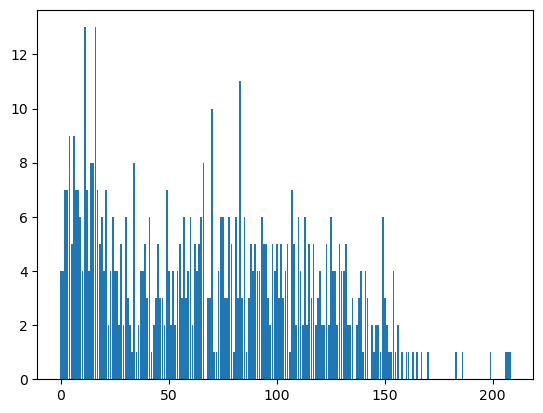

In [41]:
plt.bar(hitop_sum_counts_initialonly.hitop_sum, hitop_sum_counts_initialonly.counts)

<BarContainer object of 166 artists>

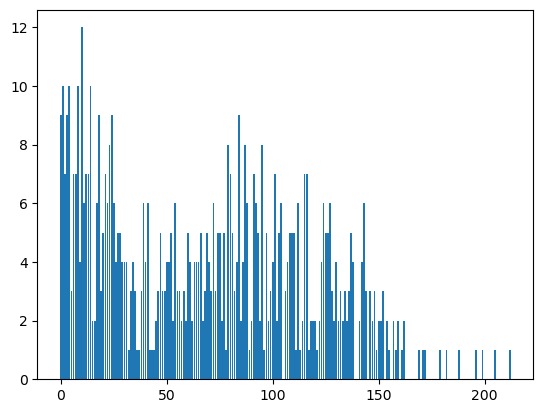

In [42]:
plt.bar(hitop_sum_counts_recontactonly.hitop_sum, hitop_sum_counts_recontactonly.counts)

In [43]:
# cfa function

In [44]:
def run_cfa_genpopvsenriched(mydata_forcfa):
    mydata = mydata_forcfa
    
    num_iter = 1000
    rprint = ro.r('print')
    summary = ro.r('summary')
    ro.r('set.seed(12345)')
    rngkind = "L'Ecuyer-CMRG"

    mdl_strs_new_new = {'hitop_SUM': 'hitop_SUM =~hitop_anhedonic_depression + hitop_anxious_worry + hitop_appetite_gain + hitop_appetite_loss + hitop_cognitive_problems + hitop_hyposomnia + hitop_indecisiveness + hitop_insomnia + hitop_panic + hitop_separation_insecurity + hitop_shame_guilt + hitop_situational_phobia + hitop_social_anxiety', 
    'baars_SUM': 'baars_SUM = ~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9 + hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5 + impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4 + sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9', # ~inattention_sum + hyperactivity_sum + impulsivity_sum + sct_sum',
    'phq_SUM': 'phq_SUM =~phq_1 + phq_2 + phq_3 + phq_4 + phq_5 + phq_6 + phq_7 + phq_8',
    'gad_SUM': 'gad_SUM =~gad_1 + gad_2 + gad_3 + gad_4 + gad_5 + gad_6 + gad_7',
    'baars_inattention_SUM': 'baars_inattention_SUM =~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9',
    'baars_hyperactivity_SUM': 'baars_hyperactivity_SUM =~hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5',
    'baars_impulsivity_SUM': 'baars_impulsivity_SUM =~impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4',
    'baars_sct_SUM': 'baars_sct_SUM =~sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9',
    'anhedonic_depression': 'anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop92 + hitop93 + hitop123 + hitop157 + hitop182 + hitop230 + hitop246',
    'anxious_worry': 'anxious_worry =~hitop20 + hitop34 + hitop89 + hitop203 + hitop248 + hitop265',
    'appetite_gain': 'appetite_gain =~hitop120 + hitop141 + hitop243 + hitop275',
    'hyposomnia': 'hyposomnia =~hitop5 + hitop66 + hitop99 + hitop181 + hitop231',
    'insomnia': 'insomnia =~hitop160 + hitop254 + hitop261 + hitop268',
    'panic': 'panic =~hitop15 + hitop104 + hitop126 + hitop211 + hitop215 + hitop257',
    'separation_insecurity': 'separation_insecurity =~hitop40 + hitop50 + hitop69 + hitop81 + hitop113 + hitop136 + hitop151 + hitop197',
    'shame_guilt': 'shame_guilt =~hitop72 + hitop140 + hitop143 + hitop220',
    'situational_phobia': 'situational_phobia =~hitop16 + hitop165 + hitop225 + hitop247 + hitop278',
    'social_anxiety': 'social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258',
    'well_being': 'well_being =~hitop9 + hitop23 + hitop54 + hitop106 + hitop149 + hitop200 + hitop244 + hitop245 + hitop250 + hitop281'}                  

    mydata.to_csv('../data/CFA/data_genpopvsenriched.csv')
    ro.r("rdata <- read.csv('../data/CFA/data_genpopvsenriched.csv', header=TRUE)") 
    group = 'genpop_or_enriched'

    ro.globalenv['group'] = group
    
    # CFA
    df_data = [] 
    for cln_ss, mdl in mdl_strs_new_new.items():
        do_metric = False
        do_scalar = False
        do_strict = False
        print("\n")
        print(cln_ss.upper())
        print(mdl)
        print("\n")
        # ====== CONFIG =====        
        ro.globalenv[cln_ss+'_mdl'] = mdl_strs_new_new[cln_ss]
        fit_config = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV")')
        ro.globalenv['fit_config'] = fit_config        
        out_config = semtools.permuteMeasEq(nPermute=num_iter, # 100 for now, 1000 for the "real" run
                                                    con=fit_config, # In the case of testing configural invariance when modelType = "mgcfa", con is the configural model (implicitly, the unconstrained model is the saturated model, so use the defaults uncon = NULL and param = NULL).
                                                    parallelType="multicore", ncpus=4)
        config_p = extract_p(out_config)
        if float(config_p) >= 0.05:
            print('CONFIG INVARIANT chisq p = ' + str(config_p))
            do_metric = True
        else:
            (passed_flag, my_cfi, my_tli, my_rmsea) = check_secondary_criteria(fit_config)
            if passed_flag:
                print('CONFIG chisq p = ' + str(config_p))
                print('PASSED SECONDARY CRITERIA WITH CFI = ' + str(my_cfi) + ' TLI = ' + str(my_tli) + ' RMSEA = ' + str(my_rmsea))
                do_metric = True
            else:
                print('CONFIG INVARIANT NOT PASSED, chisq p = ' + str(config_p))
       
        if do_metric:
    
            # ====== METRIC =====
            fit_metric = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal="loadings")')
            ro.globalenv['fit_metric'] = fit_metric
            out_metric = semtools.permuteMeasEq(nPermute=num_iter, 
                                                    uncon=fit_config, 
                                                    con=fit_metric, 
                                                    param="loadings",
                                                    parallelType="multicore", ncpus=4)
            metric_p = extract_p(out_metric)
            if float(metric_p) >= 0.05:
                print('METRIC INVARIANT chisq p = ' + str(metric_p))
                do_scalar = True
            else:
                # significant:
                print('METRIC INVARIANT NOT PASSED, chisq p = ' + str(metric_p))
                _ = print_problematic_items(out_metric)
                
            if do_scalar:
                # ====== SCALAR =====
                ro.globalenv['out_metric'] = out_metric
                fit_scalar = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal=c("loadings", "intercepts"))')
                ro.globalenv['fit_scalar'] = fit_scalar
                out_scalar = semtools.permuteMeasEq(nPermute=num_iter, 
                                                    uncon=fit_metric, 
                                                    con=fit_scalar, 
                                                    param=ro.StrVector(["loadings","intercepts"]),
                                                    parallelType="multicore", 
                                                    ncpus=4)
                scalar_p = extract_p(out_scalar)
                if float(scalar_p) >= 0.05:
                    print('SCALAR INVARIANT chisq p = ' + str(scalar_p))
                    do_strict = True
                else:
                    # significant:
                    print('SCALAR INVARIANT NOT PASSED, chisq p = ' + str(scalar_p))
                    _ = print_problematic_items(out_scalar)
    
                if do_strict:
    
                    # ====== STRICT =====
                    ro.globalenv['out_scalar'] = out_scalar
                    fit_strict = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal=c("loadings", "intercepts", "residuals"))')
                    ro.globalenv['fit_strict'] = fit_strict
                    out_strict = semtools.permuteMeasEq(nPermute=num_iter, 
                                                            uncon=fit_scalar, 
                                                            con=fit_strict, 
                                                            param=ro.StrVector(["loadings","intercepts", "residuals"]),
                                                            parallelType="multicore", 
                                                            ncpus=4)
                    strict_p = extract_p(out_strict)
                    if float(strict_p) >= 0.05:
                        print('STRICT INVARIANT chisq p = ' + str(strict_p))
                    else:
                        # significant:
                        print('STRICT INVARIANT NOT PASSED, chisq p = ' + str(strict_p))
                        _ = print_problematic_items(out_strict)
    
                else:
                    print('STRICT N/A')
                    strict_p = 'NA'
            else:
                print('SCALAR N/A')
                print('STRICT N/A')
                scalar_p = 'NA'
                strict_p = 'NA'
        else:
            print('METRIC N/A')
            print('SCALAR N/A')
            print('STRICT N/A')
            metric_p = 'NA'
            scalar_p = 'NA'
            strict_p = 'NA'
        df_data.append({cln_ss: [config_p, metric_p, scalar_p, strict_p]})
    df = pd.DataFrame(df_data)
    
    print('DONE')

In [45]:
# data available:

#mydata_genpopenriched_full
#mydata_genpopenriched_initialonly
#mydata_genpopenriched_recontactonly

In [46]:
mydata_genpopenriched_initialonly.head()

,Subject,hitop_sum,baars_sum,phq_sum,gad_sum,mood_bothered,anxiety_bothered,attention_bothered,moodanxiety_bothered,baars_inattention_sum,baars_hyperactivity_sum,baars_impulsivity_sum,baars_sct_sum,hitop_anhedonic_depression,hitop_anxious_worry,hitop_appetite_gain,hitop_appetite_loss,hitop_cognitive_problems,hitop_hyposomnia,hitop_indecisiveness,hitop_insomnia,hitop_panic,hitop_separation_insecurity,hitop_shame_guilt,hitop_situational_phobia,hitop_social_anxiety,hitop_well_being,inattention_1,inattention_2,inattention_3,inattention_4,inattention_5,inattention_6,inattention_7,inattention_8,inattention_9,hyperactivity_1,hyperactivity_2,hyperactivity_3,hyperactivity_4,hyperactivity_5,impulsivity_1,impulsivity_2,impulsivity_3,impulsivity_4,gad_1,gad_2,gad_3,gad_4,gad_5,gad_6,gad_7,phq_1,phq_2,phq_3,phq_4,phq_5,phq_6,phq_7,phq_8,sct_1,sct_2,sct_3,sct_4,sct_5,sct_6,sct_7,sct_8,sct_9,hitop157,hitop81,hitop34,hitop54,hitop243,hitop182,hitop69,hitop89,hitop50,hitop129,hitop265,hitop124,hitop231,hitop93,hitop67,hitop245,hitop281,hitop141,hitop40,hitop204,hitop21,hitop236,hitop280,hitop84,hitop120,hitop77,hitop92,hitop258,hitop39,hitop254,hitop215,hitop95,hitop106,hitop283,hitop16,hitop20,hitop189,hitop1,hitop136,hitop246,hitop248,hitop257,hitop114,hitop117,hitop250,hitop200,hitop160,hitop23,hitop165,hitop244,hitop9,hitop142,hitop230,hitop149,hitop247,hitop99,hitop66,hitop240,hitop222,hitop90,hitop113,hitop278,hitop203,hitop159,hitop123,hitop275,hitop268,hitop225,hitop143,hitop151,hitop181,hitop211,hitop17,hitop126,hitop5,hitop261,hitop220,hitop15,hitop72,hitop140,hitop109,hitop197,hitop104,todayhitop157,todayhitop81,todayhitop34,todayhitop54,todayhitop243,todayhitop182,todayhitop69,todayhitop89,todayhitop50,todayhitop129,todayhitop265,todayhitop124,todayhitop231,todayhitop93,todayhitop67,todayhitop245,todayhitop281,todayhitop141,todayhitop40,todayhitop204,todayhitop21,todayhitop236,todayhitop280,todayhitop84,todayhitop120,todayhitop77,todayhitop92,todayhitop258,todayhitop39,todayhitop254,todayhitop215,todayhitop95,todayhitop106,todayhitop283,todayhitop16,todayhitop20,todayhitop189,todayhitop1,todayhitop136,todayhitop246,todayhitop248,todayhitop257,todayhitop114,todayhitop117,todayhitop250,todayhitop200,todayhitop160,todayhitop23,todayhitop165,todayhitop244,todayhitop9,todayhitop142,todayhitop230,todayhitop149,todayhitop247,todayhitop99,todayhitop66,todayhitop240,todayhitop222,todayhitop90,todayhitop113,todayhitop278,todayhitop203,todayhitop159,todayhitop123,todayhitop275,todayhitop268,todayhitop225,todayhitop143,todayhitop151,todayhitop181,todayhitop211,todayhitop17,todayhitop126,todayhitop5,todayhitop261,todayhitop220,todayhitop15,todayhitop72,todayhitop140,todayhitop109,todayhitop197,todayhitop104,whichvisit,genpop_or_enriched
0,0,39,16,7,10,False,False,False,False,7,7,2,15,2,11,5,0,6,0,3,1,0,4,2,0,5,28,0,1,0,0,0,1,0,3,2,1,0,1,2,3,0,2,0,0,2,2,2,2,1,1,0,0,1,0,3,0,2,1,0,0,1,2,1,3,2,3,3,0,1,1,2,3,2,1,1,1,0,1,2,0,0,0,1,3,3,2,0,1,1,1,0,0,0,0,0,0,0,0,0,1,2,0,0,1,3,1,1,0,1,0,0,1,3,2,0,3,0,3,3,1,0,3,0,0,0,1,0,1,0,0,3,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,initialvisit,genpop
1,1,93,12,4,6,False,False,False,False,6,3,3,11,10,13,5,2,6,5,3,4,12,3,3,10,17,27,1,1,1,0,0,1,0,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,1,0,0,1,0,1,0,1,1,2,2,1,2,1,1,1,1,0,1,0,3,3,0,2,0,2,0,1,3,2,0,1,2,3,3,3,1,3,1,2,1,0,1,3,1,1,0,1,0,1,3,0,2,3,1,2,0,1,1,3,1,1,0,3,2,3,3,3,3,1,1,3,3,1,2,1,3,1,1,1,0,2,0,1,0,1,1,1,1,3,1,2,1,1,1,2,0,1,1,0,2,2,2,1,1,2,2,2,2,2,2,1,2,2,2,2,1,2,1,2,2,1,2,2,2,2,2,2,1,2,1,2,2,1,2,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,1,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,initialvisit,genpop
2,3,17,4,0,0,False,False,False,False,4,0,0,3,1,0,3,0,1,0,0,6,1,0,0,4,1,13,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,

In [79]:
print(mydata_prepped_genpopenriched_full.shape)
run_cfa_genpopvsenriched(mydata_prepped_genpopenriched_full)

NameError: name 'mydata_prepped_genpopenriched_full' is not defined

In [85]:
for c in mydata_genpopenriched_initialonly.columns:
    print(c)

Subject
hitop_sum
baars_sum
phq_sum
gad_sum
mood_bothered
anxiety_bothered
attention_bothered
moodanxiety_bothered
baars_inattention_sum
baars_hyperactivity_sum
baars_impulsivity_sum
baars_sct_sum
hitop_anhedonic_depression
hitop_anxious_worry
hitop_appetite_gain
hitop_appetite_loss
hitop_cognitive_problems
hitop_hyposomnia
hitop_indecisiveness
hitop_insomnia
hitop_panic
hitop_separation_insecurity
hitop_shame_guilt
hitop_situational_phobia
hitop_social_anxiety
hitop_well_being
inattention_1
inattention_2
inattention_3
inattention_4
inattention_5
inattention_6
inattention_7
inattention_8
inattention_9
hyperactivity_1
hyperactivity_2
hyperactivity_3
hyperactivity_4
hyperactivity_5
impulsivity_1
impulsivity_2
impulsivity_3
impulsivity_4
gad_1
gad_2
gad_3
gad_4
gad_5
gad_6
gad_7
phq_1
phq_2
phq_3
phq_4
phq_5
phq_6
phq_7
phq_8
sct_1
sct_2
sct_3
sct_4
sct_5
sct_6
sct_7
sct_8
sct_9
hitop157
hitop81
hitop34
hitop54
hitop243
hitop182
hitop69
hitop89
hitop50
hitop129
hitop265
hitop124
hitop231


In [92]:
print(mydata_genpopenriched_initialonly.shape)
run_cfa_genpopvsenriched(mydata_genpopenriched_initialonly)

R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




(653, 237)


HITOP_SUM
hitop_SUM =~hitop_anhedonic_depression + hitop_anxious_worry + hitop_appetite_gain + hitop_appetite_loss + hitop_cognitive_problems + hitop_hyposomnia + hitop_indecisiveness + hitop_insomnia + hitop_panic + hitop_separation_insecurity + hitop_shame_guilt + hitop_situational_phobia + hitop_social_anxiety




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.001
PASSED SECONDARY CRITERIA WITH CFI = 0.995 TLI = 0.994 RMSEA = 0.055


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.204
SCALAR INVARIANT NOT PASSED, chisq p = 0
Problematic items:
character(0)
STRICT N/A


BAARS_SUM
baars_SUM = ~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9 + hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5 + impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4 + sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT NOT PASSED, chisq p = 0
METRIC N/A
SCALAR N/A
STRICT N/A


PHQ_SUM
phq_SUM =~phq_1 + phq_2 + phq_3 + phq_4 + phq_5 + phq_6 + phq_7 + phq_8




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.001
PASSED SECONDARY CRITERIA WITH CFI = 0.989 TLI = 0.985 RMSEA = 0.05


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.168
SCALAR INVARIANT NOT PASSED, chisq p = 0
Problematic items:
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




STRICT N/A


GAD_SUM
gad_SUM =~gad_1 + gad_2 + gad_3 + gad_4 + gad_5 + gad_6 + gad_7




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0
PASSED SECONDARY CRITERIA WITH CFI = 0.999 TLI = 0.998 RMSEA = 0.053
METRIC INVARIANT NOT PASSED, chisq p = 0.009
Problematic items:
[1] "Parameter 'gad_SUM=~gad_6' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A


BAARS_INATTENTION_SUM
baars_inattention_SUM =~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0
PASSED SECONDARY CRITERIA WITH CFI = 0.992 TLI = 0.99 RMSEA = 0.041


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.349
SCALAR INVARIANT NOT PASSED, chisq p = 0
Problematic items:
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




STRICT N/A


BAARS_HYPERACTIVITY_SUM
baars_hyperactivity_SUM =~hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.249


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.521
SCALAR INVARIANT NOT PASSED, chisq p = 0.001
Problematic items:
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




STRICT N/A


BAARS_IMPULSIVITY_SUM
baars_impulsivity_SUM =~impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.784


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.37


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR INVARIANT chisq p = 0.11
STRICT INVARIANT NOT PASSED, chisq p = 0
Problematic items:
[1] "Parameter 'impulsivity_1~~impulsivity_1' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.






BAARS_SCT_SUM
baars_sct_SUM =~sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT NOT PASSED, chisq p = 0
METRIC N/A
SCALAR N/A
STRICT N/A


ANHEDONIC_DEPRESSION
anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop92 + hitop93 + hitop123 + hitop157 + hitop182 + hitop230 + hitop246




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.019
PASSED SECONDARY CRITERIA WITH CFI = 0.991 TLI = 0.989 RMSEA = 0.046
METRIC INVARIANT NOT PASSED, chisq p = 0
Problematic items:
[1] "Parameter 'anhedonic_depression=~hitop157' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A


ANXIOUS_WORRY
anxious_worry =~hitop20 + hitop34 + hitop89 + hitop203 + hitop248 + hitop265




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.994 RMSEA = 0.037
METRIC INVARIANT NOT PASSED, chisq p = 0
Problematic items:
[1] "Parameter 'anxious_worry=~hitop265' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A


APPETITE_GAIN
appetite_gain =~hitop120 + hitop141 + hitop243 + hitop275




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.445


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.594
SCALAR INVARIANT NOT PASSED, chisq p = 0
Problematic items:
[1] "Parameter 'hitop141~1' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




STRICT N/A


HYPOSOMNIA
hyposomnia =~hitop5 + hitop66 + hitop99 + hitop181 + hitop231




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.569


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.149
SCALAR INVARIANT NOT PASSED, chisq p = 0.002
Problematic items:
[1] "Parameter 'hyposomnia=~hitop231' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'hitop231~1' may differ between Groups 'genpop' and 'enriched'."          


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




STRICT N/A


INSOMNIA
insomnia =~hitop160 + hitop254 + hitop261 + hitop268




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.092


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.361
SCALAR INVARIANT NOT PASSED, chisq p = 0.014
Problematic items:
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




STRICT N/A


PANIC
panic =~hitop15 + hitop104 + hitop126 + hitop211 + hitop215 + hitop257




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.256


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.865


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR INVARIANT chisq p = 0.164
STRICT INVARIANT NOT PASSED, chisq p = 0
Problematic items:
[1] "Parameter 'hitop215~~hitop215' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.






SEPARATION_INSECURITY
separation_insecurity =~hitop40 + hitop50 + hitop69 + hitop81 + hitop113 + hitop136 + hitop151 + hitop197




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.061


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.082


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR INVARIANT chisq p = 0.387
STRICT INVARIANT NOT PASSED, chisq p = 0
Problematic items:
[1] "Parameter 'hitop136~~hitop136' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'hitop197~~hitop197' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.






SHAME_GUILT
shame_guilt =~hitop72 + hitop140 + hitop143 + hitop220




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.152


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.739
SCALAR INVARIANT NOT PASSED, chisq p = 0
Problematic items:
[1] "Parameter 'hitop220~1' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




STRICT N/A


SITUATIONAL_PHOBIA
situational_phobia =~hitop16 + hitop165 + hitop225 + hitop247 + hitop278




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.574


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.16


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR INVARIANT chisq p = 0.1
STRICT INVARIANT NOT PASSED, chisq p = 0
Problematic items:
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.






SOCIAL_ANXIETY
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.001
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.004 RMSEA = 0.037
METRIC INVARIANT NOT PASSED, chisq p = 0
Problematic items:
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A


WELL_BEING
well_being =~hitop9 + hitop23 + hitop54 + hitop106 + hitop149 + hitop200 + hitop244 + hitop245 + hitop250 + hitop281




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.013
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.001 RMSEA = 0.044


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.345
SCALAR INVARIANT NOT PASSED, chisq p = 0
Problematic items:
character(0)
STRICT N/A
DONE


In [93]:
run_cfa_genpopvsenriched(mydata_genpopenriched_recontactonly)

R[write to console]: No AFIs were selected, so only chi-squared will be permuted.






HITOP_SUM
hitop_SUM =~hitop_anhedonic_depression + hitop_anxious_worry + hitop_appetite_gain + hitop_appetite_loss + hitop_cognitive_problems + hitop_hyposomnia + hitop_indecisiveness + hitop_insomnia + hitop_panic + hitop_separation_insecurity + hitop_shame_guilt + hitop_situational_phobia + hitop_social_anxiety




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0
PASSED SECONDARY CRITERIA WITH CFI = 0.993 TLI = 0.991 RMSEA = 0.059


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.48
SCALAR INVARIANT NOT PASSED, chisq p = 0
Problematic items:
character(0)
STRICT N/A


BAARS_SUM
baars_SUM = ~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9 + hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5 + impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4 + sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT NOT PASSED, chisq p = 0
METRIC N/A
SCALAR N/A
STRICT N/A


PHQ_SUM
phq_SUM =~phq_1 + phq_2 + phq_3 + phq_4 + phq_5 + phq_6 + phq_7 + phq_8




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.082
METRIC INVARIANT NOT PASSED, chisq p = 0.022
Problematic items:
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A


GAD_SUM
gad_SUM =~gad_1 + gad_2 + gad_3 + gad_4 + gad_5 + gad_6 + gad_7




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.001 RMSEA = 0.048
METRIC INVARIANT NOT PASSED, chisq p = 0
Problematic items:
[1] "Parameter 'gad_SUM=~gad_6' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A


BAARS_INATTENTION_SUM
baars_inattention_SUM =~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.006 RMSEA = 0.033
METRIC INVARIANT NOT PASSED, chisq p = 0.002
Problematic items:
[1] "Parameter 'baars_inattention_SUM=~inattention_4' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'baars_inattention_SUM=~inattention_6' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A


BAARS_HYPERACTIVITY_SUM
baars_hyperactivity_SUM =~hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT NOT PASSED, chisq p = 0
METRIC N/A
SCALAR N/A
STRICT N/A


BAARS_IMPULSIVITY_SUM
baars_impulsivity_SUM =~impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.214


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.825


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR INVARIANT chisq p = 0.553
STRICT INVARIANT NOT PASSED, chisq p = 0.003
Problematic items:
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.






BAARS_SCT_SUM
baars_sct_SUM =~sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT NOT PASSED, chisq p = 0
METRIC N/A
SCALAR N/A
STRICT N/A


ANHEDONIC_DEPRESSION
anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop92 + hitop93 + hitop123 + hitop157 + hitop182 + hitop230 + hitop246




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.05
METRIC INVARIANT NOT PASSED, chisq p = 0.001
Problematic items:
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A


ANXIOUS_WORRY
anxious_worry =~hitop20 + hitop34 + hitop89 + hitop203 + hitop248 + hitop265




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.034
PASSED SECONDARY CRITERIA WITH CFI = 0.998 TLI = 0.997 RMSEA = 0.029
METRIC INVARIANT NOT PASSED, chisq p = 0.031
Problematic items:
[1] "Parameter 'anxious_worry=~hitop34' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A


APPETITE_GAIN
appetite_gain =~hitop120 + hitop141 + hitop243 + hitop275




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.587


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.5


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR INVARIANT chisq p = 0.068


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




STRICT INVARIANT chisq p = 0.528


HYPOSOMNIA
hyposomnia =~hitop5 + hitop66 + hitop99 + hitop181 + hitop231




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.805
METRIC INVARIANT NOT PASSED, chisq p = 0.048
Problematic items:
[1] "Parameter 'hyposomnia=~hitop231' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A


INSOMNIA
insomnia =~hitop160 + hitop254 + hitop261 + hitop268




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 1


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.57
SCALAR INVARIANT NOT PASSED, chisq p = 0.002
Problematic items:
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




STRICT N/A


PANIC
panic =~hitop15 + hitop104 + hitop126 + hitop211 + hitop215 + hitop257




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0
PASSED SECONDARY CRITERIA WITH CFI = 0.992 TLI = 0.987 RMSEA = 0.037


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.385


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR INVARIANT chisq p = 0.218
STRICT INVARIANT NOT PASSED, chisq p = 0
Problematic items:
[1] "Parameter 'hitop15~~hitop15' may differ between Groups 'genpop' and 'enriched'."  
[2] "Parameter 'hitop211~~hitop211' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.






SEPARATION_INSECURITY
separation_insecurity =~hitop40 + hitop50 + hitop69 + hitop81 + hitop113 + hitop136 + hitop151 + hitop197




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT NOT PASSED, chisq p = 0
METRIC N/A
SCALAR N/A
STRICT N/A


SHAME_GUILT
shame_guilt =~hitop72 + hitop140 + hitop143 + hitop220




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT NOT PASSED, chisq p = 0
METRIC N/A
SCALAR N/A
STRICT N/A


SITUATIONAL_PHOBIA
situational_phobia =~hitop16 + hitop165 + hitop225 + hitop247 + hitop278




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.28
METRIC INVARIANT NOT PASSED, chisq p = 0.025
Problematic items:
[1] "Parameter 'situational_phobia=~hitop225' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A


SOCIAL_ANXIETY
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.994 RMSEA = 0.038
METRIC INVARIANT NOT PASSED, chisq p = 0
Problematic items:
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A


WELL_BEING
well_being =~hitop9 + hitop23 + hitop54 + hitop106 + hitop149 + hitop200 + hitop244 + hitop245 + hitop250 + hitop281




R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.121
METRIC INVARIANT NOT PASSED, chisq p = 0.013
Problematic items:
character(0)
SCALAR N/A
STRICT N/A
DONE


# ablations - genpop vs enriched, HiTOP

In [50]:
def run_specific_cfa2(mydata, whichscale, whichcfa):

    num_iter = 1000
    rprint = ro.r('print')
    summary = ro.r('summary')
    ro.r('set.seed(12345)')
    rngkind = "L'Ecuyer-CMRG"

    mdl_strs_new = {'hitop_SUM': 'hitop_SUM =~hitop_anhedonic_depression + hitop_anxious_worry + hitop_appetite_gain + hitop_appetite_loss + hitop_cognitive_problems + hitop_hyposomnia + hitop_indecisiveness + hitop_insomnia + hitop_panic + hitop_separation_insecurity + hitop_shame_guilt + hitop_situational_phobia + hitop_social_anxiety', 
    'baars_SUM': 'baars_SUM = ~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9 + hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5 + impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4 + sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9', # ~inattention_sum + hyperactivity_sum + impulsivity_sum + sct_sum',
    'phq_SUM': 'phq_SUM =~phq_1 + phq_2 + phq_3 + phq_4 + phq_5 + phq_6 + phq_7 + phq_8',
    'gad_SUM': 'gad_SUM =~gad_1 + gad_2 + gad_3 + gad_4 + gad_5 + gad_6 + gad_7',
    'baars_inattention_SUM': 'baars_inattention_SUM =~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9',
    'baars_hyperactivity_SUM': 'baars_hyperactivity_SUM =~hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5',
    'baars_impulsivity_SUM': 'baars_impulsivity_SUM =~impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4',
    'baars_sct_SUM': 'baars_sct_SUM =~sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9',
    'anhedonic_depression': 'anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop92 + hitop93 + hitop123 + hitop157 + hitop182 + hitop230 + hitop246',
    'anxious_worry': 'anxious_worry =~hitop20 + hitop34 + hitop89 + hitop203 + hitop248 + hitop265',
    'appetite_gain': 'appetite_gain =~hitop120 + hitop141 + hitop243 + hitop275',
    'hyposomnia': 'hyposomnia =~hitop5 + hitop66 + hitop99 + hitop181 + hitop231',
    'insomnia': 'insomnia =~hitop160 + hitop254 + hitop261 + hitop268',
    'panic': 'panic =~hitop15 + hitop104 + hitop126 + hitop211 + hitop215 + hitop257',
    'separation_insecurity': 'separation_insecurity =~hitop40 + hitop50 + hitop69 + hitop81 + hitop113 + hitop136 + hitop151 + hitop197',
    'shame_guilt': 'shame_guilt =~hitop72 + hitop140 + hitop143 + hitop220',
    'situational_phobia': 'situational_phobia =~hitop16 + hitop165 + hitop225 + hitop247 + hitop278',
    'social_anxiety': 'social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258',
    'well_being': 'well_being =~hitop9 + hitop23 + hitop54 + hitop106 + hitop149 + hitop200 + hitop244 + hitop245 + hitop250 + hitop281'}                  

    mydata.to_csv('../data/CFA/data_genpopvsenriched.csv')
    ro.r("rdata <- read.csv('../data/CFA/data_genpopvsenriched.csv', header=TRUE)") 
    group = 'genpop_or_enriched'

    ro.globalenv['group'] = group

    for cln_ss, mdl in mdl_strs_new.items():
        if cln_ss == whichscale:  
            print('lets go')
            if whichcfa == 'metric':
                do_metric = True
                do_scalar = False
                do_strict = False
            elif whichcfa == 'scalar':
                do_metric = True
                do_scalar = True
                do_strict = False   
            elif whichcfa == 'strict':
                do_metric = True
                do_scalar = True
                do_strict = True                  
            print("\n")
            print(cln_ss.upper())
            print(mdl)
            # ====== CONFIG =====        

            # loop to do ablations
            temp_items = mdl_strs_new[cln_ss]
            temp_items_items = temp_items.split("=~",1)[1]
            temp_items_items_items = temp_items_items.split(" + ")
            list_of_items = temp_items_items_items
            for item in list_of_items:
                print('\nITEM TO REMOVE: ' + item)
                mynewstring = temp_items.split("=~",1)[0] + "=~"
                temp_items_items_items.remove(item)
                for x in temp_items_items_items:
                    mynewstring += x + ' + '
                temp_items_items_items = temp_items_items.split(" + ")
                mynewstring = mynewstring[:-3]
                print(mynewstring)
            
                ro.globalenv[cln_ss+'_mdl'] = mynewstring           
            
                fit_config = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV")')
                ro.globalenv['fit_config'] = fit_config        
                out_config = semtools.permuteMeasEq(nPermute=num_iter, # 100 for now, 1000 for the "real" run
                                                        con=fit_config, # In the case of testing configural invariance when modelType = "mgcfa", con is the configural model (implicitly, the unconstrained model is the saturated model, so use the defaults uncon = NULL and param = NULL).
                                                        parallelType="multicore", ncpus=4)
                config_p = extract_p(out_config)
                if float(config_p) >= 0.05:
                    print('CONFIG INVARIANT chisq p = ' + str(config_p))
                else:
                    (passed_flag, my_cfi, my_tli, my_rmsea) = check_secondary_criteria(fit_config)
                    if passed_flag:
                        print('CONFIG chisq p = ' + str(config_p))
                        print('PASSED SECONDARY CRITERIA WITH CFI = ' + str(my_cfi) + ' TLI = ' + str(my_tli) + ' RMSEA = ' + str(my_rmsea))
                    else:
                        print('CONFIG INVARIANT NOT PASSED, chisq p = ' + str(config_p))
                if do_metric:
                    # ====== METRIC =====
                    fit_metric = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal="loadings")')
                    ro.globalenv['fit_metric'] = fit_metric
                    out_metric = semtools.permuteMeasEq(nPermute=num_iter, 
                                                        uncon=fit_config, 
                                                        con=fit_metric, 
                                                        param="loadings",
                                                        parallelType="multicore", ncpus=4)
                    metric_p = extract_p(out_metric)
                    if float(metric_p) >= 0.05:
                        print('METRIC INVARIANT chisq p = ' + str(metric_p))
                    else:
                        # significant:
                        print('METRIC INVARIANT NOT PASSED, chisq p = ' + str(metric_p))
                        ro.globalenv['out_metric'] = out_metric
                        ro.r("myoutputmetric <- capture.output(summary(out_metric))") 
                        ro.r("stringid <- grep(\"chisq\", myoutputmetric)")
                        ro.r("print(myoutputmetric[stringid-1])")
                        ro.r("print(myoutputmetric[stringid])")
                        # significant:
                        ro.r("stringidsig <- grep(\"may differ between Groups\", myoutputmetric)")
                        ro.r("print(myoutputmetric[stringidsig])")
                    if do_scalar:
                        # ====== SCALAR =====
                        ro.globalenv['out_metric'] = out_metric
                        fit_scalar = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal=c("loadings", "intercepts"))')
                        ro.globalenv['fit_scalar'] = fit_scalar
                        out_scalar = semtools.permuteMeasEq(nPermute=num_iter, 
                                                        uncon=fit_metric, 
                                                        con=fit_scalar, 
                                                        param=ro.StrVector(["loadings","intercepts"]),
                                                        parallelType="multicore", 
                                                        ncpus=4)
                        scalar_p = extract_p(out_scalar)
                        if float(scalar_p) >= 0.05:
                            print('SCALAR INVARIANT chisq p = ' + str(scalar_p))
                        else:
                            # significant:
                            print('SCALAR INVARIANT NOT PASSED, chisq p = ' + str(scalar_p))
                            _ = print_problematic_items(out_scalar)
                            ro.globalenv['out_scalar'] = out_scalar
                            ro.r("myoutputscalar <- capture.output(summary(out_scalar))") 
                            ro.r("stringid <- grep(\"chisq\", myoutputscalar)")
                            ro.r("print(myoutputscalar[stringid-1])")
                            ro.r("print(myoutputscalar[stringid])")
                            # significant:
                            ro.r("stringidsig <- grep(\"may differ between Groups\", myoutputscalar)")
                            ro.r("print(myoutputscalar[stringidsig])")
                        if do_strict:
                            # ====== STRICT =====
                            ro.globalenv['out_scalar'] = out_scalar
                            fit_strict = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal=c("loadings", "intercepts", "residuals"))')
                            ro.globalenv['fit_strict'] = fit_strict
                            out_strict = semtools.permuteMeasEq(nPermute=num_iter, 
                                                                uncon=fit_scalar, 
                                                                con=fit_strict, 
                                                                param=ro.StrVector(["loadings","intercepts", "residuals"]),
                                                                parallelType="multicore", 
                                                                ncpus=4)
                            strict_p = extract_p(out_strict)
                            if float(strict_p) >= 0.05:
                                print('STRICT INVARIANT chisq p = ' + str(strict_p))
                            else:
                                # significant:
                                print('STRICT INVARIANT NOT PASSED, chisq p = ' + str(strict_p))
                                _ = print_problematic_items(out_strict)
                                ro.globalenv['out_strict'] = out_strict
                                ro.r("myoutputstrict <- capture.output(summary(out_strict))") 
                                ro.r("stringid <- grep(\"chisq\", myoutputstrict)")
                                ro.r("print(myoutputstrict[stringid-1])")
                                ro.r("print(myoutputstrict[stringid])")
                                # significant:
                                ro.r("stringidsig <- grep(\"may differ between Groups\", myoutputstrict)")
                                ro.r("print(myoutputstrict[stringidsig])")
                        else:
                            print('STRICT N/A')
                            strict_p = 'NA'
                    else:
                        print('SCALAR N/A')
                        print('STRICT N/A')
                        scalar_p = 'NA'
                        strict_p = 'NA'
                else:
                    print('METRIC N/A')
                    print('SCALAR N/A')
                    print('STRICT N/A')
                    metric_p = 'NA'
                    scalar_p = 'NA'
                    strict_p = 'NA'
    print("DONE")
    return(0)



In [54]:
def run_specific_cfa3(mydata, whichscale, whichcfa, howmanyitems):
    print('THIS ONE RUNS ALL COMBINATIONS OF ITEMS')
    num_iter = 1000
    rprint = ro.r('print')
    summary = ro.r('summary')
    ro.r('set.seed(12345)')
    rngkind = "L'Ecuyer-CMRG"

    mdl_strs_new = {'hitop_SUM': 'hitop_SUM =~hitop_anhedonic_depression + hitop_anxious_worry + hitop_appetite_gain + hitop_appetite_loss + hitop_cognitive_problems + hitop_hyposomnia + hitop_indecisiveness + hitop_insomnia + hitop_panic + hitop_separation_insecurity + hitop_shame_guilt + hitop_situational_phobia + hitop_social_anxiety', 
    'baars_SUM': 'baars_SUM = ~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9 + hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5 + impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4 + sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9', # ~inattention_sum + hyperactivity_sum + impulsivity_sum + sct_sum',
    'phq_SUM': 'phq_SUM =~phq_1 + phq_2 + phq_3 + phq_4 + phq_5 + phq_6 + phq_7 + phq_8',
    'gad_SUM': 'gad_SUM =~gad_1 + gad_2 + gad_3 + gad_4 + gad_5 + gad_6 + gad_7',
    'baars_inattention_SUM': 'baars_inattention_SUM =~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9',
    'baars_hyperactivity_SUM': 'baars_hyperactivity_SUM =~hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5',
    'baars_impulsivity_SUM': 'baars_impulsivity_SUM =~impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4',
    'baars_sct_SUM': 'baars_sct_SUM =~sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9',
    'anhedonic_depression': 'anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop92 + hitop93 + hitop123 + hitop157 + hitop182 + hitop230 + hitop246',
    'anxious_worry': 'anxious_worry =~hitop20 + hitop34 + hitop89 + hitop203 + hitop248 + hitop265',
    'appetite_gain': 'appetite_gain =~hitop120 + hitop141 + hitop243 + hitop275',
    'hyposomnia': 'hyposomnia =~hitop5 + hitop66 + hitop99 + hitop181 + hitop231',
    'insomnia': 'insomnia =~hitop160 + hitop254 + hitop261 + hitop268',
    'panic': 'panic =~hitop15 + hitop104 + hitop126 + hitop211 + hitop215 + hitop257',
    'separation_insecurity': 'separation_insecurity =~hitop40 + hitop50 + hitop69 + hitop81 + hitop113 + hitop136 + hitop151 + hitop197',
    'shame_guilt': 'shame_guilt =~hitop72 + hitop140 + hitop143 + hitop220',
    'situational_phobia': 'situational_phobia =~hitop16 + hitop165 + hitop225 + hitop247 + hitop278',
    'social_anxiety': 'social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258',
    'well_being': 'well_being =~hitop9 + hitop23 + hitop54 + hitop106 + hitop149 + hitop200 + hitop244 + hitop245 + hitop250 + hitop281'}                  

    mydata.to_csv('../data/CFA/data_genpopvsenriched.csv')
    ro.r("rdata <- read.csv('../data/CFA/data_genpopvsenriched.csv', header=TRUE)") 
    group = 'genpop_or_enriched'

    ro.globalenv['group'] = group

    for cln_ss, mdl in mdl_strs_new.items():
        if cln_ss == whichscale:  
            print('lets go')
            if whichcfa == 'metric':
                do_metric = True
                do_scalar = False
                do_strict = False
            elif whichcfa == 'scalar':
                do_metric = True
                do_scalar = True
                do_strict = False   
            elif whichcfa == 'strict':
                do_metric = True
                do_scalar = True
                do_strict = True                  
            print("\n")
            print(cln_ss.upper())
            print(mdl)
            # ====== CONFIG ===== 
            # loop to do ablations
            temp_items = mdl_strs_new[cln_ss]
            temp_items_items = temp_items.split("=~",1)[1]
            temp_items_items_items = temp_items_items.split(" + ")
            list_of_items = temp_items_items_items

            for com in combinations(list_of_items, howmanyitems):
                print('\nCOMBINATIONS OF ITEMS: ')
                print(com)
                mynewstring = temp_items.split("=~",1)[0] + "=~"
                for x in com:
                    mynewstring += x + ' + '
                mynewstring = mynewstring[:-3]
                print(mynewstring)
            
                ro.globalenv[cln_ss+'_mdl'] = mynewstring           
            
                fit_config = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV")')
                ro.globalenv['fit_config'] = fit_config        
                out_config = semtools.permuteMeasEq(nPermute=num_iter, # 100 for now, 1000 for the "real" run
                                                        con=fit_config, # In the case of testing configural invariance when modelType = "mgcfa", con is the configural model (implicitly, the unconstrained model is the saturated model, so use the defaults uncon = NULL and param = NULL).
                                                        parallelType="multicore", ncpus=4)
                config_p = extract_p(out_config)
                if float(config_p) >= 0.05:
                    print('CONFIG INVARIANT chisq p = ' + str(config_p))
                else:
                    (passed_flag, my_cfi, my_tli, my_rmsea) = check_secondary_criteria(fit_config)
                    if passed_flag:
                        print('CONFIG chisq p = ' + str(config_p))
                        print('PASSED SECONDARY CRITERIA WITH CFI = ' + str(my_cfi) + ' TLI = ' + str(my_tli) + ' RMSEA = ' + str(my_rmsea))
                    else:
                        print('CONFIG INVARIANT NOT PASSED, chisq p = ' + str(config_p))
                if do_metric:
                    # ====== METRIC =====
                    fit_metric = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal="loadings")')
                    ro.globalenv['fit_metric'] = fit_metric
                    out_metric = semtools.permuteMeasEq(nPermute=num_iter, 
                                                        uncon=fit_config, 
                                                        con=fit_metric, 
                                                        param="loadings",
                                                        parallelType="multicore", ncpus=4)
                    metric_p = extract_p(out_metric)
                    if float(metric_p) >= 0.05:
                        print('METRIC INVARIANT chisq p = ' + str(metric_p))
                    else:
                        # significant:
                        print('METRIC INVARIANT NOT PASSED, chisq p = ' + str(metric_p))
                        ro.globalenv['out_metric'] = out_metric
                        ro.r("myoutputmetric <- capture.output(summary(out_metric))") 
                        ro.r("stringid <- grep(\"chisq\", myoutputmetric)")
                        ro.r("print(myoutputmetric[stringid-1])")
                        ro.r("print(myoutputmetric[stringid])")
                        # significant:
                        ro.r("stringidsig <- grep(\"may differ between Groups\", myoutputmetric)")
                        ro.r("print(myoutputmetric[stringidsig])")
                    if do_scalar:
                        # ====== SCALAR =====
                        ro.globalenv['out_metric'] = out_metric
                        fit_scalar = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal=c("loadings", "intercepts"))')
                        ro.globalenv['fit_scalar'] = fit_scalar
                        out_scalar = semtools.permuteMeasEq(nPermute=num_iter, 
                                                        uncon=fit_metric, 
                                                        con=fit_scalar, 
                                                        param=ro.StrVector(["loadings","intercepts"]),
                                                        parallelType="multicore", 
                                                        ncpus=4)
                        scalar_p = extract_p(out_scalar)
                        if float(scalar_p) >= 0.05:
                            print('SCALAR INVARIANT chisq p = ' + str(scalar_p))
                        else:
                            # significant:
                            print('SCALAR INVARIANT NOT PASSED, chisq p = ' + str(scalar_p))
                            _ = print_problematic_items(out_scalar)
                            ro.globalenv['out_scalar'] = out_scalar
                            ro.r("myoutputscalar <- capture.output(summary(out_scalar))") 
                            ro.r("stringid <- grep(\"chisq\", myoutputscalar)")
                            ro.r("print(myoutputscalar[stringid-1])")
                            ro.r("print(myoutputscalar[stringid])")
                            # significant:
                            ro.r("stringidsig <- grep(\"may differ between Groups\", myoutputscalar)")
                            ro.r("print(myoutputscalar[stringidsig])")
                        if do_strict:
                            # ====== STRICT =====
                            ro.globalenv['out_scalar'] = out_scalar
                            fit_strict = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal=c("loadings", "intercepts", "residuals"))')
                            ro.globalenv['fit_strict'] = fit_strict
                            out_strict = semtools.permuteMeasEq(nPermute=num_iter, 
                                                                uncon=fit_scalar, 
                                                                con=fit_strict, 
                                                                param=ro.StrVector(["loadings","intercepts", "residuals"]),
                                                                parallelType="multicore", 
                                                                ncpus=4)
                            strict_p = extract_p(out_strict)
                            if float(strict_p) >= 0.05:
                                print('STRICT INVARIANT chisq p = ' + str(strict_p))
                            else:
                                # significant:
                                print('STRICT INVARIANT NOT PASSED, chisq p = ' + str(strict_p))
                                _ = print_problematic_items(out_strict)
                                ro.globalenv['out_strict'] = out_strict
                                ro.r("myoutputstrict <- capture.output(summary(out_strict))") 
                                ro.r("stringid <- grep(\"chisq\", myoutputstrict)")
                                ro.r("print(myoutputstrict[stringid-1])")
                                ro.r("print(myoutputstrict[stringid])")
                                # significant:
                                ro.r("stringidsig <- grep(\"may differ between Groups\", myoutputstrict)")
                                ro.r("print(myoutputstrict[stringidsig])")
                        else:
                            print('STRICT N/A')
                            strict_p = 'NA'
                    else:
                        print('SCALAR N/A')
                        print('STRICT N/A')
                        scalar_p = 'NA'
                        strict_p = 'NA'
                else:
                    print('METRIC N/A')
                    print('SCALAR N/A')
                    print('STRICT N/A')
                    metric_p = 'NA'
                    scalar_p = 'NA'
                    strict_p = 'NA'
    print("DONE")
    return(0)

In [52]:
run_specific_cfa2(mydata_genpopenriched_initialonly, 
                 whichscale = 'anhedonic_depression', 
                 whichcfa = 'metric')

R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




lets go


ANHEDONIC_DEPRESSION
anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop92 + hitop93 + hitop123 + hitop157 + hitop182 + hitop230 + hitop246

ITEM TO REMOVE: hitop39
anhedonic_depression =~hitop77 + hitop84 + hitop92 + hitop93 + hitop123 + hitop157 + hitop182 + hitop230 + hitop246


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.007
PASSED SECONDARY CRITERIA WITH CFI = 0.99 TLI = 0.986 RMSEA = 0.049
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         71.487       0"
[1] "Parameter 'anhedonic_depression=~hitop157' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop84
anhedonic_depression =~hitop39 + hitop77 + hitop92 + hitop93 + hitop123 + hitop157 + hitop182 + hitop230 + hitop246


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.005
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.997 RMSEA = 0.052
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq          81.39       0"
[1] "Parameter 'anhedonic_depression=~hitop157' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop92
anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop93 + hitop123 + hitop157 + hitop182 + hitop230 + hitop246


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.53
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq          82.68       0"
[1] "Parameter 'anhedonic_depression=~hitop157' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop93
anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop92 + hitop123 + hitop157 + hitop182 + hitop230 + hitop246


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.005
PASSED SECONDARY CRITERIA WITH CFI = 0.998 TLI = 0.998 RMSEA = 0.05
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq         57.793   0.001"
[1] "Parameter 'anhedonic_depression=~hitop157' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop123
anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop92 + hitop93 + hitop157 + hitop182 + hitop230 + hitop246


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.006
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.002 RMSEA = 0.041
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq         60.352   0.001"
[1] "Parameter 'anhedonic_depression=~hitop157' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop157
anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop92 + hitop93 + hitop123 + hitop182 + hitop230 + hitop246


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.05
METRIC INVARIANT NOT PASSED, chisq p = 0.005
[1] "      AFI.Difference p.value"
[1] "chisq         42.954   0.005"
[1] "Parameter 'anhedonic_depression=~hitop92' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop182
anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop92 + hitop93 + hitop123 + hitop157 + hitop230 + hitop246


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.007
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.996 RMSEA = 0.052
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq         68.089   0.001"
[1] "Parameter 'anhedonic_depression=~hitop157' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop230
anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop92 + hitop93 + hitop123 + hitop157 + hitop182 + hitop246


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.021
PASSED SECONDARY CRITERIA WITH CFI = 0.999 TLI = 0.999 RMSEA = 0.049
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         82.141       0"
[1] "Parameter 'anhedonic_depression=~hitop157' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop246
anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop92 + hitop93 + hitop123 + hitop157 + hitop182 + hitop230


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.106
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         83.755       0"
[1] "Parameter 'anhedonic_depression=~hitop157' may differ between Groups 'genpop' and 'enriched'."
SCALAR N/A
STRICT N/A
DONE


0

In [62]:
run_specific_cfa2(mydata_genpopenriched_initialonly, 
                 whichscale = 'anxious_worry', 
                 whichcfa = 'metric')

R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




lets go


ANXIOUS_WORRY
anxious_worry =~hitop20 + hitop34 + hitop89 + hitop203 + hitop248 + hitop265

ITEM TO REMOVE: hitop20
anxious_worry =~hitop34 + hitop89 + hitop203 + hitop248 + hitop265


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.016
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.003 RMSEA = 0.04
METRIC INVARIANT NOT PASSED, chisq p = 0.048
[1] "      AFI.Difference p.value"
[1] "chisq           7.86   0.048"
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop89
anxious_worry =~hitop20 + hitop34 + hitop203 + hitop248 + hitop265


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.027
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.007 RMSEA = 0.019
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq         17.588   0.001"
[1] "Parameter 'anxious_worry=~hitop265' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop203
anxious_worry =~hitop20 + hitop34 + hitop89 + hitop248 + hitop265


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.001
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.005 RMSEA = 0.032
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq          22.91       0"
[1] "Parameter 'anxious_worry=~hitop265' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop248
anxious_worry =~hitop20 + hitop34 + hitop89 + hitop203 + hitop265


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.007
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.002 RMSEA = 0.041
METRIC INVARIANT NOT PASSED, chisq p = 0.003
[1] "      AFI.Difference p.value"
[1] "chisq         14.235   0.003"
[1] "Parameter 'anxious_worry=~hitop89' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop265
anxious_worry =~hitop20 + hitop34 + hitop89 + hitop203 + hitop248


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.002
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.001 RMSEA = 0.045
METRIC INVARIANT chisq p = 0.06
SCALAR N/A
STRICT N/A
DONE


0

In [66]:
run_specific_cfa2(mydata_genpopenriched_initialonly, 
                 whichscale = 'social_anxiety', 
                 whichcfa = 'metric')

R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




lets go


SOCIAL_ANXIETY
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258

ITEM TO REMOVE: hitop1
social_anxiety =~hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.004
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.994 RMSEA = 0.038
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         64.493       0"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop114
social_anxiety =~hitop1 + hitop17 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.005
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.995 RMSEA = 0.035
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         63.482       0"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop117
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.015
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.996 RMSEA = 0.033
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq          53.98       0"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop124
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.006
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.996 RMSEA = 0.033
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         63.548       0"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop129
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.004 RMSEA = 0.036
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         62.903       0"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop204
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.003
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.004 RMSEA = 0.037
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq          51.84   0.001"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop222
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.003
PASSED SECONDARY CRITERIA WITH CFI = 0.995 TLI = 0.993 RMSEA = 0.041
METRIC INVARIANT NOT PASSED, chisq p = 0.003
[1] "      AFI.Difference p.value"
[1] "chisq         45.138   0.003"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop236
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.003
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.994 RMSEA = 0.038
METRIC INVARIANT NOT PASSED, chisq p = 0.003
[1] "      AFI.Difference p.value"
[1] "chisq         42.625   0.003"
[1] "Parameter 'social_anxiety=~hitop117' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

ITEM TO REMOVE: hitop258
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.004
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.004 RMSEA = 0.037
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         54.518       0"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."
SCALAR N/A
STRICT N/A
DONE


0

In [67]:
# let's do stubborn ones
run_specific_cfa3(mydata_genpopenriched_initialonly, 
                 whichscale = 'social_anxiety', 
                 whichcfa = 'metric',
                 howmanyitems = 8)

R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




THIS ONE RUNS ALL COMBINATIONS OF ITEMS
lets go


SOCIAL_ANXIETY
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop222')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.016
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.994 RMSEA = 0.038
METRIC INVARIANT NOT PASSED, chisq p = 0.007
[1] "      AFI.Difference p.value"
[1] "chisq         33.003   0.007"
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop236')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop236


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.003
PASSED SECONDARY CRITERIA WITH CFI = 0.995 TLI = 0.993 RMSEA = 0.041
METRIC INVARIANT NOT PASSED, chisq p = 0.012
[1] "      AFI.Difference p.value"
[1] "chisq         31.692   0.012"
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.003
PASSED SECONDARY CRITERIA WITH CFI = 0.994 TLI = 0.992 RMSEA = 0.044
METRIC INVARIANT NOT PASSED, chisq p = 0.016
[1] "      AFI.Difference p.value"
[1] "chisq          27.03   0.016"
[1] "Parameter 'social_anxiety=~hitop117' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop222', 'hitop236')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop222 + hitop236


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.012
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.995 RMSEA = 0.037
METRIC INVARIANT NOT PASSED, chisq p = 0.005
[1] "      AFI.Difference p.value"
[1] "chisq         37.621   0.005"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop222', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop222 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.001
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.003 RMSEA = 0.038
METRIC INVARIANT NOT PASSED, chisq p = 0.01
[1] "      AFI.Difference p.value"
[1] "chisq         28.438    0.01"
[1] "Parameter 'social_anxiety=~hitop117' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.001
PASSED SECONDARY CRITERIA WITH CFI = 0.995 TLI = 0.993 RMSEA = 0.042
METRIC INVARIANT NOT PASSED, chisq p = 0.007
[1] "      AFI.Difference p.value"
[1] "chisq         31.779   0.007"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop204', 'hitop222', 'hitop236')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop204 + hitop222 + hitop236


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.002
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.003 RMSEA = 0.037
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq          46.82   0.001"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop204', 'hitop222', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop204 + hitop222 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.001
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.995 RMSEA = 0.038
METRIC INVARIANT NOT PASSED, chisq p = 0.004
[1] "      AFI.Difference p.value"
[1] "chisq         37.281   0.004"
[1] "Parameter 'social_anxiety=~hitop117' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop204', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop204 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.994 RMSEA = 0.039
METRIC INVARIANT NOT PASSED, chisq p = 0.004
[1] "      AFI.Difference p.value"
[1] "chisq         39.958   0.004"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.004
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.996 RMSEA = 0.032
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq         44.997   0.001"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop129', 'hitop204', 'hitop222', 'hitop236')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop129 + hitop204 + hitop222 + hitop236


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.011
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.006 RMSEA = 0.029
METRIC INVARIANT NOT PASSED, chisq p = 0.002
[1] "      AFI.Difference p.value"
[1] "chisq         46.234   0.002"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop129', 'hitop204', 'hitop222', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop129 + hitop204 + hitop222 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.017
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.996 RMSEA = 0.032
METRIC INVARIANT NOT PASSED, chisq p = 0.002
[1] "      AFI.Difference p.value"
[1] "chisq         38.716   0.002"
[1] "Parameter 'social_anxiety=~hitop117' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop129', 'hitop204', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop129 + hitop204 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.007
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.995 RMSEA = 0.037
METRIC INVARIANT NOT PASSED, chisq p = 0.002
[1] "      AFI.Difference p.value"
[1] "chisq          41.96   0.002"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop129', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop129 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.013
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.996 RMSEA = 0.033
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq         44.184   0.001"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop117', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.004 RMSEA = 0.035
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         55.406       0"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop236')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.032
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.996 RMSEA = 0.032
METRIC INVARIANT NOT PASSED, chisq p = 0.003
[1] "      AFI.Difference p.value"
[1] "chisq          42.02   0.003"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop124 + hitop129 + hitop204 + hitop222 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.012
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.004 RMSEA = 0.035


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.066
SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop124', 'hitop129', 'hitop204', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop124 + hitop129 + hitop204 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.012
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.994 RMSEA = 0.038
METRIC INVARIANT NOT PASSED, chisq p = 0.004
[1] "      AFI.Difference p.value"
[1] "chisq         35.144   0.004"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop124', 'hitop129', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop124 + hitop129 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.021
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.005 RMSEA = 0.033
METRIC INVARIANT NOT PASSED, chisq p = 0.004
[1] "      AFI.Difference p.value"
[1] "chisq         38.327   0.004"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop124', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop124 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.015
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.005 RMSEA = 0.032
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq         47.623   0.001"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop114', 'hitop129', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.063
METRIC INVARIANT NOT PASSED, chisq p = 0.002
[1] "      AFI.Difference p.value"
[1] "chisq         46.655   0.002"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop236')
social_anxiety =~hitop1 + hitop17 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.034
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.004 RMSEA = 0.035
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq          45.71       0"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.031
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.996 RMSEA = 0.034
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq         39.637   0.001"
[1] "Parameter 'social_anxiety=~hitop117' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop117 + hitop124 + hitop129 + hitop204 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.001
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.003 RMSEA = 0.04
METRIC INVARIANT NOT PASSED, chisq p = 0.003
[1] "      AFI.Difference p.value"
[1] "chisq         37.087   0.003"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop117', 'hitop124', 'hitop129', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop117 + hitop124 + hitop129 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.018
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.995 RMSEA = 0.037
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         45.622       0"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop117', 'hitop124', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop117 + hitop124 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.002
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.004 RMSEA = 0.034
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         54.857       0"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop117', 'hitop129', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop117 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.012
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.996 RMSEA = 0.034
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         55.993       0"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop17', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop17 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.014
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.005 RMSEA = 0.032
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         48.168       0"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop236')
social_anxiety =~hitop1 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.004
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.002 RMSEA = 0.041
METRIC INVARIANT NOT PASSED, chisq p = 0.006
[1] "      AFI.Difference p.value"
[1] "chisq         36.073   0.006"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop258')
social_anxiety =~hitop1 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.001
PASSED SECONDARY CRITERIA WITH CFI = 0.995 TLI = 0.993 RMSEA = 0.042
METRIC INVARIANT NOT PASSED, chisq p = 0.01
[1] "      AFI.Difference p.value"
[1] "chisq         29.878    0.01"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.001
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.001 RMSEA = 0.046
METRIC INVARIANT NOT PASSED, chisq p = 0.037
[1] "      AFI.Difference p.value"
[1] "chisq         23.842   0.037"
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop114 + hitop117 + hitop124 + hitop129 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.002
PASSED SECONDARY CRITERIA WITH CFI = 0.995 TLI = 0.993 RMSEA = 0.042
METRIC INVARIANT NOT PASSED, chisq p = 0.006
[1] "      AFI.Difference p.value"
[1] "chisq         34.023   0.006"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop114', 'hitop117', 'hitop124', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop114 + hitop117 + hitop124 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.001
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.994 RMSEA = 0.04
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq         43.343   0.001"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop114', 'hitop117', 'hitop129', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop114 + hitop117 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.005
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.995 RMSEA = 0.036
METRIC INVARIANT NOT PASSED, chisq p = 0.002
[1] "      AFI.Difference p.value"
[1] "chisq         43.885   0.002"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop114', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop114 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.017
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.995 RMSEA = 0.034
METRIC INVARIANT NOT PASSED, chisq p = 0.003
[1] "      AFI.Difference p.value"
[1] "chisq         38.272   0.003"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop1', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop1 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.994 RMSEA = 0.041
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         44.688       0"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop236')
social_anxiety =~hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.004
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.994 RMSEA = 0.039
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq         50.443   0.001"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop258')
social_anxiety =~hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.003
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.994 RMSEA = 0.038
METRIC INVARIANT NOT PASSED, chisq p = 0.003
[1] "      AFI.Difference p.value"
[1] "chisq         35.329   0.003"
[1] "Parameter 'social_anxiety=~hitop117' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop236', 'hitop258')
social_anxiety =~hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.003
PASSED SECONDARY CRITERIA WITH CFI = 0.994 TLI = 0.992 RMSEA = 0.043
METRIC INVARIANT NOT PASSED, chisq p = 0.004
[1] "      AFI.Difference p.value"
[1] "chisq         38.758   0.004"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.006
PASSED SECONDARY CRITERIA WITH CFI = 0.996 TLI = 0.994 RMSEA = 0.039
METRIC INVARIANT NOT PASSED, chisq p = 0.002
[1] "      AFI.Difference p.value"
[1] "chisq         46.186   0.002"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop17', 'hitop114', 'hitop117', 'hitop124', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop17 + hitop114 + hitop117 + hitop124 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.001
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.003 RMSEA = 0.038
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq         56.322       0"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop17', 'hitop114', 'hitop117', 'hitop129', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop17 + hitop114 + hitop117 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.022
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.004 RMSEA = 0.035
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq         57.172   0.001"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop17', 'hitop114', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop17 + hitop114 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG INVARIANT chisq p = 0.114
METRIC INVARIANT NOT PASSED, chisq p = 0.001
[1] "      AFI.Difference p.value"
[1] "chisq         49.763   0.001"
[1] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop17', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop17 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.044
PASSED SECONDARY CRITERIA WITH CFI = 0.997 TLI = 0.996 RMSEA = 0.032
METRIC INVARIANT NOT PASSED, chisq p = 0
[1] "      AFI.Difference p.value"
[1] "chisq           57.7       0"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




SCALAR N/A
STRICT N/A

COMBINATIONS OF ITEMS: 
('hitop114', 'hitop117', 'hitop124', 'hitop129', 'hitop204', 'hitop222', 'hitop236', 'hitop258')
social_anxiety =~hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.009
PASSED SECONDARY CRITERIA WITH CFI = 0.995 TLI = 0.993 RMSEA = 0.041
METRIC INVARIANT NOT PASSED, chisq p = 0.002
[1] "      AFI.Difference p.value"
[1] "chisq         44.179   0.002"
[1] "Parameter 'social_anxiety=~hitop222' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'social_anxiety=~hitop236' may differ between Groups 'genpop' and 'enriched'."
SCALAR N/A
STRICT N/A
DONE


0

In [68]:
def load_item_lookup():
    # this is a table that aligns scale items with their corresponding questions
    htqs = pd.read_excel('../data/ValSample/Internalizing-Somatoform Items_DW.xlsx', skiprows=2,
                                names=['id', 'scale', 'item', '_0', '_1', '_2', '_3']).drop(['_0', '_1', '_2', '_3'], axis=1)
    # cmqs is a dataframe with items and responses
    # htcm is the same dataframe, but only displaying HiTOP items
    cmqs = pd.read_csv('../data/CFA/cogmood_questions.csv')
    cmqs = cmqs.rename({'Unnamed: 0': 'id'}, axis=1)
    htcm = cmqs.query("measure == 'HiTOP'")
    # this is a lookup table for subscales, items (sentence questions), and hitop ids
    item_lookup = htcm.loc[:, ['id','subscale', 'item']].merge(htqs.loc[:, ['id','item']], how='inner', on='item', suffixes=['_cm', '_ht'])
    item_lookup['htid'] = 'hitop'+ item_lookup.id_ht.astype(str)
    return(item_lookup)

#social_anxiety =~hitop1 + hitop17 + hitop114 + hitop117 + hitop124 + hitop129 + hitop204 + hitop222 + hitop236 + hitop258
item_lookup = load_item_lookup()
items_to_check = ['117', '236', '1', '17', '114', '124', '129', '204', '222', '258']
for i in items_to_check:
    a = repr(item_lookup.loc[item_lookup['htid'] == 'hitop'+i]['htid']).split(' ', 1)[1]
    aa = str(a).split('\n')[0]
    b = repr(item_lookup.loc[item_lookup['htid'] == 'hitop'+i]['item']).split(' ', 1)[1]
    bb = str(b).split('\n')[0]
    print(aa+' : '+bb)

   hitop117 :    I felt socially awkward.
   hitop236 :    I felt self-conscious around others.
   hitop1 :    I felt shy around other people.
   hitop17 :    I was uncomfortable meeting new people.
   hitop114 :    I had difficulty making eye contact with others.
   hitop124 :    I avoided situations in which others were likely to watch me.
   hitop129 :    I avoided performing or giving a talk in front of others.
   hitop204 :    I felt uncomfortable being the center of attention.
   hitop222 :    I was uncomfortable entering a room when others already were present.
   hitop258 :    I found it difficult to speak up in front of others.


/Users/zeleninam2/Documents/projects/hitop/2-analysis-CFA/env/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [69]:
def run_specific_cfa(mydata, whichscale, whichcfa):
    print('! DONT FORGET TO CHANGE MDL_STRS_NEW BELOW IN CODE FOR ABLATION EXPERIMENTS')
    num_iter = 1000
    rprint = ro.r('print')
    summary = ro.r('summary')
    ro.r('set.seed(12345)')
    rngkind = "L'Ecuyer-CMRG"

    mdl_strs_new = {'hitop_SUM': 'hitop_SUM =~hitop_anhedonic_depression + hitop_anxious_worry + hitop_appetite_gain + hitop_appetite_loss + hitop_cognitive_problems + hitop_hyposomnia + hitop_indecisiveness + hitop_insomnia + hitop_panic + hitop_separation_insecurity + hitop_shame_guilt + hitop_situational_phobia + hitop_social_anxiety', 
    'baars_SUM': 'baars_SUM = ~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9 + hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5 + impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4 + sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9', # ~inattention_sum + hyperactivity_sum + impulsivity_sum + sct_sum',
    'phq_SUM': 'phq_SUM =~phq_1 + phq_2 + phq_3 + phq_4 + phq_5 + phq_6 + phq_7 + phq_8',
    'gad_SUM': 'gad_SUM =~gad_1 + gad_2 + gad_3 + gad_4 + gad_5 + gad_6 + gad_7',
    'baars_inattention_SUM': 'baars_inattention_SUM =~inattention_1 + inattention_2 + inattention_3 + inattention_4 + inattention_5 + inattention_6 + inattention_7 + inattention_8 + inattention_9',
    'baars_hyperactivity_SUM': 'baars_hyperactivity_SUM =~hyperactivity_1 + hyperactivity_2 + hyperactivity_3 + hyperactivity_4 + hyperactivity_5',
    'baars_impulsivity_SUM': 'baars_impulsivity_SUM =~impulsivity_1 + impulsivity_2 + impulsivity_3 + impulsivity_4',
    'baars_sct_SUM': 'baars_sct_SUM =~sct_1 + sct_2 + sct_3 + sct_4 + sct_5 + sct_6 + sct_7 + sct_8 + sct_9',
    'anhedonic_depression': 'anhedonic_depression =~hitop39 + hitop77 + hitop84 + hitop93 + hitop123 + hitop182 + hitop230 + hitop246', #92, 157
    'anxious_worry': 'anxious_worry =~hitop20 + hitop34 + hitop89 + hitop203 + hitop248', #265
    'appetite_gain': 'appetite_gain =~hitop120 + hitop141 + hitop243 + hitop275',
    'hyposomnia': 'hyposomnia =~hitop5 + hitop66 + hitop99 + hitop181 + hitop231',
    'insomnia': 'insomnia =~hitop160 + hitop254 + hitop261 + hitop268',
    'panic': 'panic =~hitop15 + hitop104 + hitop126 + hitop211 + hitop215 + hitop257',
    'separation_insecurity': 'separation_insecurity =~hitop40 + hitop50 + hitop69 + hitop81 + hitop113 + hitop136 + hitop151 + hitop197',
    'shame_guilt': 'shame_guilt =~hitop72 + hitop140 + hitop143 + hitop220',
    'situational_phobia': 'situational_phobia =~hitop16 + hitop165 + hitop225 + hitop247 + hitop278',
    'social_anxiety': 'social_anxiety =~hitop1 + hitop17 + hitop114 + hitop124 + hitop129 + hitop204 + hitop222 + hitop258', #117, 236
    'well_being': 'well_being =~hitop9 + hitop23 + hitop54 + hitop106 + hitop149 + hitop200 + hitop244 + hitop245 + hitop250 + hitop281'}                  

    mydata.to_csv('../data/CFA/data_genpopvsenriched.csv')
    ro.r("rdata <- read.csv('../data/CFA/data_genpopvsenriched.csv', header=TRUE)") 
    group = 'genpop_or_enriched'

    ro.globalenv['group'] = group

    for cln_ss, mdl in mdl_strs_new.items():
        if cln_ss == whichscale:  
            print('lets go')
            if whichcfa == 'metric':
                do_metric = True
                do_scalar = False
                do_strict = False
            elif whichcfa == 'scalar':
                do_metric = True
                do_scalar = True
                do_strict = False   
            elif whichcfa == 'strict':
                do_metric = True
                do_scalar = True
                do_strict = True                  
            print("\n")
            print(cln_ss.upper())
            print(mdl)
            # ====== CONFIG =====        
            ro.globalenv[cln_ss+'_mdl'] = mdl_strs_new[cln_ss]
            fit_config = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV")')
            ro.globalenv['fit_config'] = fit_config        
            out_config = semtools.permuteMeasEq(nPermute=num_iter, # 100 for now, 1000 for the "real" run
                                                    con=fit_config, # In the case of testing configural invariance when modelType = "mgcfa", con is the configural model (implicitly, the unconstrained model is the saturated model, so use the defaults uncon = NULL and param = NULL).
                                                    parallelType="multicore", ncpus=4)
            config_p = extract_p(out_config)
            if float(config_p) >= 0.05:
                print('CONFIG INVARIANT chisq p = ' + str(config_p))
            else:
                (passed_flag, my_cfi, my_tli, my_rmsea) = check_secondary_criteria(fit_config)
                if passed_flag:
                    print('CONFIG chisq p = ' + str(config_p))
                    print('PASSED SECONDARY CRITERIA WITH CFI = ' + str(my_cfi) + ' TLI = ' + str(my_tli) + ' RMSEA = ' + str(my_rmsea))
                else:
                    print('CONFIG INVARIANT NOT PASSED, chisq p = ' + str(config_p))
            if do_metric:
                # ====== METRIC =====
                fit_metric = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal="loadings")')
                ro.globalenv['fit_metric'] = fit_metric
                out_metric = semtools.permuteMeasEq(nPermute=num_iter, 
                                                    uncon=fit_config, 
                                                    con=fit_metric, 
                                                    param="loadings",
                                                    parallelType="multicore", ncpus=4)
                metric_p = extract_p(out_metric)
                if float(metric_p) >= 0.05:
                    print('METRIC INVARIANT chisq p = ' + str(metric_p))
                else:
                    # significant:
                    print('METRIC INVARIANT NOT PASSED, chisq p = ' + str(metric_p))
                    ro.globalenv['out_metric'] = out_metric
                    ro.r("myoutputmetric <- capture.output(summary(out_metric))") 
                    ro.r("stringid <- grep(\"chisq\", myoutputmetric)")
                    ro.r("print(myoutputmetric[stringid-1])")
                    ro.r("print(myoutputmetric[stringid])")
                    # significant:
                    ro.r("stringidsig <- grep(\"may differ between Groups\", myoutputmetric)")
                    ro.r("print(myoutputmetric[stringidsig])")
                if do_scalar:
                    # ====== SCALAR =====
                    ro.globalenv['out_metric'] = out_metric
                    fit_scalar = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal=c("loadings", "intercepts"))')
                    ro.globalenv['fit_scalar'] = fit_scalar
                    out_scalar = semtools.permuteMeasEq(nPermute=num_iter, 
                                                    uncon=fit_metric, 
                                                    con=fit_scalar, 
                                                    param=ro.StrVector(["loadings","intercepts"]),
                                                    parallelType="multicore", 
                                                    ncpus=4)
                    scalar_p = extract_p(out_scalar)
                    if float(scalar_p) >= 0.05:
                        print('SCALAR INVARIANT chisq p = ' + str(scalar_p))
                    else:
                        # significant:
                        print('SCALAR INVARIANT NOT PASSED, chisq p = ' + str(scalar_p))
                        _ = print_problematic_items(out_scalar)
                        ro.globalenv['out_scalar'] = out_scalar
                        ro.r("myoutputscalar <- capture.output(summary(out_scalar))") 
                        ro.r("stringid <- grep(\"chisq\", myoutputscalar)")
                        ro.r("print(myoutputscalar[stringid-1])")
                        ro.r("print(myoutputscalar[stringid])")
                        # significant:
                        ro.r("stringidsig <- grep(\"may differ between Groups\", myoutputscalar)")
                        ro.r("print(myoutputscalar[stringidsig])")
                    if do_strict:
                        # ====== STRICT =====
                        ro.globalenv['out_scalar'] = out_scalar
                        fit_strict = ro.r(f'cfa({cln_ss}_mdl, data = rdata, group = group, estimator = "WLSMV", group.equal=c("loadings", "intercepts", "residuals"))')
                        ro.globalenv['fit_strict'] = fit_strict
                        out_strict = semtools.permuteMeasEq(nPermute=num_iter, 
                                                            uncon=fit_scalar, 
                                                            con=fit_strict, 
                                                            param=ro.StrVector(["loadings","intercepts", "residuals"]),
                                                            parallelType="multicore", 
                                                            ncpus=4)
                        strict_p = extract_p(out_strict)
                        if float(strict_p) >= 0.05:
                            print('STRICT INVARIANT chisq p = ' + str(strict_p))
                        else:
                            # significant:
                            print('STRICT INVARIANT NOT PASSED, chisq p = ' + str(strict_p))
                            _ = print_problematic_items(out_strict)
                            ro.globalenv['out_strict'] = out_strict
                            ro.r("myoutputstrict <- capture.output(summary(out_strict))") 
                            ro.r("stringid <- grep(\"chisq\", myoutputstrict)")
                            ro.r("print(myoutputstrict[stringid-1])")
                            ro.r("print(myoutputstrict[stringid])")
                            # significant:
                            ro.r("stringidsig <- grep(\"may differ between Groups\", myoutputstrict)")
                            ro.r("print(myoutputstrict[stringidsig])")
                    else:
                        print('STRICT N/A')
                        strict_p = 'NA'
                else:
                    print('SCALAR N/A')
                    print('STRICT N/A')
                    scalar_p = 'NA'
                    strict_p = 'NA'
            else:
                print('METRIC N/A')
                print('SCALAR N/A')
                print('STRICT N/A')
                metric_p = 'NA'
                scalar_p = 'NA'
                strict_p = 'NA'
    print("DONE")
    return(0) 

In [70]:
run_specific_cfa(mydata_genpopenriched_initialonly, 
                 whichscale = 'social_anxiety', 
                 whichcfa = 'strict')

R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




! DONT FORGET TO CHANGE MDL_STRS_NEW BELOW IN CODE FOR ABLATION EXPERIMENTS
lets go


SOCIAL_ANXIETY
social_anxiety =~hitop1 + hitop17 + hitop114 + hitop124 + hitop129 + hitop204 + hitop222 + hitop258


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




CONFIG chisq p = 0.012
PASSED SECONDARY CRITERIA WITH CFI = 1.0 TLI = 1.004 RMSEA = 0.035


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




METRIC INVARIANT chisq p = 0.066
SCALAR INVARIANT NOT PASSED, chisq p = 0
Problematic items:
character(0)
[1] "      AFI.Difference p.value"
[1] "chisq         12.803       0"
character(0)


R[write to console]: No AFIs were selected, so only chi-squared will be permuted.




STRICT INVARIANT NOT PASSED, chisq p = 0
Problematic items:
[1] "Parameter 'hitop114~~hitop114' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'hitop222~~hitop222' may differ between Groups 'genpop' and 'enriched'."
[1] "      AFI.Difference p.value"
[1] "chisq         65.339       0"
[1] "Parameter 'hitop114~~hitop114' may differ between Groups 'genpop' and 'enriched'."
[2] "Parameter 'hitop222~~hitop222' may differ between Groups 'genpop' and 'enriched'."
DONE


0